The following code is commented out

        with torch.no_grad():
            idx_closest_to_zero_m4 = np.argmin(np.abs(alpha_x_ctrl_4))
            alpha_x_ctrl_4[idx_closest_to_zero_m4] = 0.0

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import shutil
import copy
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
import json

If you are in a Colab environment, you might do something like:<br>
from google.colab import drive<br>
drive.mount('/content/drive')<br>
data_path = '/content/drive/MyDrive/...'<br>
result_path = '/content/drive/MyDrive/...'<br>
Instead, you can set:

In [2]:
data_path = './Data_Hao2006_processed'

In [3]:
n_epochs = 5000
patience_threshold = 0.0001
patience_check_period = 200

In [4]:
m4_rng_ini = 3

In [5]:
m3_rng_ini = 2

In [6]:
n_slices_to_plot = 4

1) Create the date/time string (e.g. "20250127_152955")

In [7]:
execution_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
# 2) Form the save path using that timestamp
result_path = os.path.join('./torch_fit_result', 'run_result_' + execution_datetime)
if __name__ == "__main__":
    # 3) Make the directory if it doesn't exist
    os.makedirs(result_path, exist_ok=True)
    print(f"Directory to save: {result_path}")

Directory to save: ./torch_fit_result/run_result_20250609_022317


In [8]:
data_file_m3 = 'data_for_torch_fitting_m=3_vdis_4_weight.pkl'
data_file_m4 = 'data_for_torch_fitting_m=4_vdis_4_weight.pkl'
model_savename = "model_state" + execution_datetime + ".pt"

Output save (uncomment below if the print output (texts) needs to be saved as a .txt file); in Jupyter, it doesn't print at all.

In [9]:
# import sys
# class DualOutput:
#     def __init__(self, filename):
#         self.terminal = sys.stdout
#         self.log = open(filename, "w")
#     def write(self, message):
#         self.terminal.write(message)
#         self.log.write(message)
#     def flush(self):
#         self.terminal.flush()
#         self.log.flush()
# # Redirect standard output to DualOutput
# if __name__ == "__main__":
#     sys.stdout = DualOutput(os.path.join(result_path, "python_output.txt"))

%

In [10]:
class grid_info:
    """Simple container for storing axis info in the loaded data."""
    def __init__(self, x_min, x_max, x_size, y_min, y_max, y_size, z_min, z_max, z_size):
        self.x_min = x_min
        self.x_max = x_max
        self.x_size = x_size
        self.y_min = y_min
        self.y_max = y_max
        self.y_size = y_size
        self.z_min = z_min
        self.z_max = z_max
        self.z_size = z_size
        self.x_rng = np.linspace(x_min, x_max, x_size)
        self.y_rng = np.linspace(y_min, y_max, y_size)
        self.z_rng = np.linspace(z_min, z_max, z_size)
        self.delta_x = (x_max - x_min)/(x_size - 1) if x_size>1 else 1.0
        self.delta_y = (y_max - y_min)/(y_size - 1) if y_size>1 else 1.0
        self.delta_z = (z_max - z_min)/(z_size - 1) if z_size>1 else 1.0

-----------------------------------------------------------------------------------<br>
2) Define Names for m=3 and m=4 Cases<br>
-----------------------------------------------------------------------------------

In [11]:
Z_name = r"$q$"
X3_name = r"$a_3/a$"
Y3_name = r"$\phi_3-\phi_0$"
X4_name = r"$a_4/a$"
Y4_name = r"$\phi_4-\phi_0$"

-----------------------------------------------------------------------------------<br>
3) Load Data for m=3 and m=4<br>
-----------------------------------------------------------------------------------

In [12]:
def data_file_loader():
    with open(os.path.join(data_path, data_file_m3), 'rb') as f:
        my_grid3, P_X3Y3Z_Hao = pickle.load(f)
    with open(os.path.join(data_path, data_file_m4), 'rb') as f:
        my_grid4, P_X4Y4Z_Hao = pickle.load(f)
    return my_grid3, P_X3Y3Z_Hao, my_grid4, P_X4Y4Z_Hao

In [13]:
my_grid3, P_X3Y3Z_Hao, my_grid4, P_X4Y4Z_Hao = data_file_loader()

For convenience in code, rename these so it's clear which is which:

In [14]:
x3_rng = my_grid3.x_rng
y3_rng = my_grid3.y_rng
delta_x3 = my_grid3.delta_x
delta_y3 = my_grid3.delta_y

In [15]:
x4_rng = my_grid4.x_rng
y4_rng = my_grid4.y_rng
delta_x4 = my_grid4.delta_x
delta_y4 = my_grid4.delta_y
# delta_z is presumably the same as above or redefined from my_grid4 if they differ.

In [16]:
assert (my_grid3.z_rng == my_grid4.z_rng).all()
assert my_grid3.delta_z == my_grid4.delta_z
z_rng  = my_grid3.z_rng
delta_z  = my_grid3.delta_z  # z is shared across both m=3 and m=4.

-----------------------------------------------------------------------------------<br>
4) Define Utility Functions (PDF Evaluations, Linear Interpolation, etc.)<br>
-----------------------------------------------------------------------------------

In [17]:
def skew_normal_pdf(x, alpha, xi, omega):
    """
    Skew normal PDF:   2/omega * phi( (x - xi)/omega ) * Phi( alpha * ((x - xi)/omega ) )
    """
    normal = torch.distributions.Normal(
        loc=torch.tensor(0.0, device=x.device),
        scale=torch.tensor(1.0, device=x.device)
    )
    X_centered = (x - xi) / omega
    pdf = (2.0 / omega) * torch.exp(normal.log_prob(X_centered)) * normal.cdf(alpha * X_centered)
    return pdf

In [18]:
def generalized_gaussian_unnorm(x, alpha, beta):
    """
    'Generalized Gaussian' unnormalized form: exp( -|x - alpha|^beta ).
    """
    return torch.exp(-torch.abs(x / alpha)**beta)

In [19]:
def flat_unnorm(x):
    return torch.ones_like(x)

In [20]:
def linear_spline_eval(x, x_ctrl, y_ctrl):
    """
    Evaluate a 1D linear spline with control points (x_ctrl, y_ctrl) at positions x.
    We now explicitly sort x_ctrl, y_ctrl each call to ensure ascending order.
    """
    # # Convert to tensors
    if type(x_ctrl) in [torch.Tensor, torch.nn.Parameter]:
        pass
    else:
        x_ctrl = torch.tensor(x_ctrl, dtype=x.dtype, device=x.device)
    if type(y_ctrl) in [torch.Tensor, torch.nn.Parameter]:
        pass
    else:
        y_ctrl = torch.tensor(y_ctrl, dtype=x.dtype, device=x.device)

    # Sort in ascending order
    x_ctrl_sorted, sorted_indices = torch.sort(x_ctrl)
    y_ctrl_sorted = y_ctrl[sorted_indices]

    # Clamp x to [x_ctrl_sorted[0], x_ctrl_sorted[-1]] so we can safely interpolate
    x_clamped = torch.clamp(x, min=x_ctrl_sorted[0], max=x_ctrl_sorted[-1])

    # Find sub-interval for each x
    idxs = torch.searchsorted(x_ctrl_sorted, x_clamped, right=True)
    idxs = torch.clamp(idxs, 1, len(x_ctrl_sorted)-1)

    # Linear interpolation
    x0 = x_ctrl_sorted[idxs-1]
    x1 = x_ctrl_sorted[idxs]
    y0 = y_ctrl_sorted[idxs-1]
    y1 = y_ctrl_sorted[idxs]
    w = (x_clamped - x0) / (x1 - x0 + 1e-12)
    y = y0 + w * (y1 - y0)
    return y

In [21]:
def _get_least_informative_index(x_vals, y_vals):
    abs_slope_diff = _get_abs_slope_diff(x_vals, y_vals)
    idx_remove = np.argmin(abs_slope_diff)
    return idx_remove

In [22]:
def _get_abs_slope_diff(x_vals, y_vals):
    slopes_before = []
    slopes_after = []
    for i in range(len(x_vals)):
        if i == 0:
            sb = 0
        else:
            sb = (y_vals[i] - y_vals[i - 1]) / (x_vals[i] - x_vals[i - 1] + 1e-12)
        if i == len(x_vals) - 1:
            sa = 0
        else:
            sa = (y_vals[i + 1] - y_vals[i]) / (x_vals[i + 1] - x_vals[i] + 1e-12)
        slopes_before.append(sb)
        slopes_after.append(sa)
    slope_diff = np.array(slopes_after) - np.array(slopes_before)
    abs_slope_diff = np.abs(slope_diff)
    return abs_slope_diff

In [23]:
def _remove_one_index(xv, yv, idx_remove):
    new_xv = np.delete(xv, idx_remove)
    new_yv = np.delete(yv, idx_remove)
    return new_xv, new_yv

In [24]:
def _plot_before_removal(x_vals, y_vals, idx_remove, param_label, product_array=None):
    plt.figure()
    plt.plot(x_vals, y_vals, marker='o', label='Before removal')
    plt.scatter([x_vals[idx_remove]], [y_vals[idx_remove]], color='red', zorder=5)
    if product_array is not None:
        plt.title(f"Removing idx={idx_remove} from {param_label}, product diff={product_array[idx_remove]:.3g}")
    else:
        plt.title(f"Removing idx={idx_remove} from {param_label}")
    plt.legend()
    plt.show()

In [25]:
def _plot_after_removal(x_vals, y_vals, param_label):
    plt.figure()
    plt.plot(x_vals, y_vals, marker='o', label='After removal')
    plt.title(f"After removal {param_label}")
    plt.legend()
    plt.show()
# -----------------------------------------------------------------------------------
# 6) Define DistributionModel
# -----------------------------------------------------------------------------------
class DistributionModel(nn.Module):
    def __init__(self, z_parameters, m3_parameters, m4_parameters, my_grid3, my_grid4,
                 n_interp_m3=5, n_interp_m4=8,
                 use_identical_domain_m3=False, use_identical_domain_m4=False):
        super().__init__()
        self.n_interp_m3 = n_interp_m3
        self.n_interp_m4 = n_interp_m4

        # Define range limits
        self.x3_min = my_grid3.x_min
        self.x3_max = my_grid3.x_max
        self.y3_min = my_grid3.y_min
        self.y3_max = my_grid3.y_max
        self.x4_min = my_grid4.x_min
        self.x4_max = my_grid4.x_max
        self.y4_min = my_grid4.y_min
        self.y4_max = my_grid4.y_max
        assert my_grid3.z_min == my_grid4.z_min
        assert my_grid3.z_max == my_grid4.z_max
        self.z_min = my_grid3.z_min
        self.z_max = my_grid3.z_max

        # P(Z) skew normal parameters: alpha, xi, omega
        self.alpha_Z = nn.Parameter(torch.tensor(z_parameters["alpha_Z"], dtype=torch.float32))
        self.xi_Z    = nn.Parameter(torch.tensor(z_parameters["xi_Z"],    dtype=torch.float32))
        self.omega_Z = nn.Parameter(torch.tensor(z_parameters["omega_Z"], dtype=torch.float32))

        # Convert x_ctrl values to unconstrained space
        self.sigma_z_x_ctrl_3_unconstrained = nn.Parameter(
            self.inverse_sigmoid_init(m3_parameters["sigma_z_x_ctrl_3"], self.z_min, self.z_max)
        )

        # Fix one alpha_x_ctrl_4 entry to 0 (closest to zero)
        # alpha_x_ctrl_3 = m3_parameters["alpha_x_ctrl_3"]
        # with torch.no_grad():
        #     idx_closest_to_zero_m3 = np.argmin(np.abs(alpha_x_ctrl_3))
        #     alpha_x_ctrl_3[idx_closest_to_zero_m3] = 0.0
        # self.alpha_x_ctrl_3_unconstrained = nn.Parameter(
        #     self.inverse_sigmoid_init(alpha_x_ctrl_3, self.x3_min, self.x3_max)
        # )
        #
        # self.beta_x_ctrl_3_unconstrained = nn.Parameter(
        #     self.inverse_sigmoid_init(m3_parameters["beta_x_ctrl_3"], self.x3_min, self.x3_max)
        # )
        self.alpha_z_x_ctrl_4_unconstrained = nn.Parameter(
            self.inverse_sigmoid_init(m4_parameters["alpha_z_x_ctrl_4"], self.z_min, self.z_max)
        )
        self.xi_z_x_ctrl_4_unconstrained = nn.Parameter(
            self.inverse_sigmoid_init(m4_parameters["xi_z_x_ctrl_4"], self.z_min, self.z_max)
        )
        self.omega_z_x_ctrl_4_unconstrained = nn.Parameter(
            self.inverse_sigmoid_init(m4_parameters["omega_z_x_ctrl_4"], self.z_min, self.z_max)
        )

        # Fix one alpha_x_ctrl_4 entry to 0 (closest to zero)
        alpha_x_ctrl_4 = m4_parameters["alpha_x_ctrl_4"]
        # with torch.no_grad():
        #     idx_closest_to_zero_m4 = np.argmin(np.abs(alpha_x_ctrl_4))
        #     alpha_x_ctrl_4[idx_closest_to_zero_m4] = 0.0
        self.alpha_x_ctrl_4_unconstrained = nn.Parameter(
            self.inverse_sigmoid_init(alpha_x_ctrl_4, self.x4_min, self.x4_max)
        )
        self.beta_x_ctrl_4_unconstrained = nn.Parameter(
            self.inverse_sigmoid_init(m4_parameters["beta_x_ctrl_4"], self.x4_min, self.x4_max)
        )

        # Keep y_ctrl parameters unchanged
        self.sigma_z_y_ctrl_3 = nn.Parameter(torch.tensor(m3_parameters["sigma_z_y_ctrl_3"], dtype=torch.float32))
        # self.alpha_y_ctrl_3 = nn.Parameter(torch.tensor(m3_parameters["alpha_y_ctrl_3"], dtype=torch.float32))
        # self.beta_y_ctrl_3 = nn.Parameter(torch.tensor(m3_parameters["beta_y_ctrl_3"], dtype=torch.float32))
        self.alpha_z_y_ctrl_4 = nn.Parameter(torch.tensor(m4_parameters["alpha_z_y_ctrl_4"], dtype=torch.float32))
        self.xi_z_y_ctrl_4 = nn.Parameter(torch.tensor(m4_parameters["xi_z_y_ctrl_4"], dtype=torch.float32))
        self.omega_z_y_ctrl_4 = nn.Parameter(torch.tensor(m4_parameters["omega_z_y_ctrl_4"], dtype=torch.float32))
        self.alpha_y_ctrl_4 = nn.Parameter(torch.tensor(m4_parameters["alpha_y_ctrl_4"], dtype=torch.float32))
        self.beta_y_ctrl_4 = nn.Parameter(torch.tensor(m4_parameters["beta_y_ctrl_4"], dtype=torch.float32))

        # self._fixed_alpha_index_m3 = idx_closest_to_zero_m3
        # self._fixed_alpha_index_m4 = idx_closest_to_zero_m4

        # Structure to store best results
        self.best_results = {}
    def inverse_sigmoid_init(self, x_init, lo, hi):
        """ Converts values in range [lo, hi] into unconstrained space. """
        x_init = np.array(x_init, dtype=np.float32)
        x_norm = (x_init - lo) / (hi - lo)  # Normalize to [0,1]
        x_norm = np.clip(x_norm, 1e-6, 1 - 1e-6)  # Avoid logit(0) or logit(1)
        return torch.tensor(np.log(x_norm / (1 - x_norm)), dtype=torch.float)

    # Define properties to get constrained values
    @property
    def sigma_z_x_ctrl_3(self):
        return self.z_min + (self.z_max - self.z_min) * torch.sigmoid(self.sigma_z_x_ctrl_3_unconstrained)

    # @property
    # def alpha_x_ctrl_3(self):
    #     return self.x3_min + (self.x3_max - self.x3_min) * torch.sigmoid(self.alpha_x_ctrl_3_unconstrained)
    #
    # @property
    # def beta_x_ctrl_3(self):
    #     return self.x3_min + (self.x3_max - self.x3_min) * torch.sigmoid(self.beta_x_ctrl_3_unconstrained)
    @property
    def alpha_z_x_ctrl_4(self):
        return self.z_min + (self.z_max - self.z_min) * torch.sigmoid(self.alpha_z_x_ctrl_4_unconstrained)
    @property
    def xi_z_x_ctrl_4(self):
        return self.z_min + (self.z_max - self.z_min) * torch.sigmoid(self.xi_z_x_ctrl_4_unconstrained)
    @property
    def omega_z_x_ctrl_4(self):
        return self.z_min + (self.z_max - self.z_min) * torch.sigmoid(self.omega_z_x_ctrl_4_unconstrained)
    @property
    def alpha_x_ctrl_4(self):
        return self.x4_min + (self.x4_max - self.x4_min) * torch.sigmoid(self.alpha_x_ctrl_4_unconstrained)
    @property
    def beta_x_ctrl_4(self):
        return self.x4_min + (self.x4_max - self.x4_min) * torch.sigmoid(self.beta_x_ctrl_4_unconstrained)

    # def fix_alpha_x_ctrl_4_grad(self):
    #     """Zero out the gradient for the pinned alpha_x_ctrl_4 entry."""
    #     if self.alpha_x_ctrl_4_unconstrained.grad is not None:
    #         self.alpha_x_ctrl_4_unconstrained.grad[self._fixed_alpha_index_m4] = 0.0
    # def fix_alpha_x_ctrl_3_grad(self):
    #     """Zero out the gradient for the pinned alpha_x_ctrl_4 entry."""
    #     if self.alpha_x_ctrl_3_unconstrained.grad is not None:
    #         self.alpha_x_ctrl_3_unconstrained.grad[self._fixed_alpha_index_m3] = 0.0
    def sigma_function(self, z_tensor, x_ctrl, y_ctrl):
        # no exponential transformation needed
        with torch.no_grad():
            y_ctrl.copy_(y_ctrl.abs())
        raw_val = linear_spline_eval(z_tensor, x_ctrl, y_ctrl)
        return raw_val
    def pz(self, z_tensor, single_point=False, single_point_integration_n=100):
        """
        P(Z): skew normal pdf, normalized over z. We'll integrate along the last dimension.
        """
        val = skew_normal_pdf(z_tensor, self.alpha_Z, self.xi_Z, self.omega_Z)
        if single_point:
            # normalization
            x_norm = torch.linspace(self.z_min, self.z_max, single_point_integration_n)
            y_norm = skew_normal_pdf(x_norm, self.alpha_Z, self.xi_Z, self.omega_Z)
            norm = torch.trapz(y_norm, x=x_norm)
            val = val / (norm + 1e-12)
        else:
            dim_z = -1
            val_int = torch.trapz(val, x=z_tensor, dim=dim_z)
            val = val / (val_int.unsqueeze(dim_z) + 1e-12)
        return val
    def px3z(self, x3_tensor, z_tensor, single_point=False, single_point_integration_n=100):
        """
        P(X3|Z): Gaussian(0, sigma(z)), normalized over x3.
        """
        sigma_val = self.sigma_function(z_tensor, self.sigma_z_x_ctrl_3, self.sigma_z_y_ctrl_3)
        normal = torch.distributions.Normal(
            loc=torch.tensor(0.0, device=x3_tensor.device),
            scale=sigma_val
        )
        pdf_val = torch.exp(normal.log_prob(x3_tensor))
        if single_point:
            x_norm = torch.linspace(self.x3_min, self.x3_max, single_point_integration_n)
            normal = torch.distributions.Normal(loc=x_norm, scale=sigma_val)
            y_norm = torch.exp(normal.log_prob(x3_tensor))
            norm = torch.trapz(y_norm, x=x_norm)
            pdf_val = pdf_val / (norm + 1e-12)
        else:
            dim_x = 0
            pdf_int = torch.trapz(pdf_val, x=x3_tensor, dim=dim_x)
            pdf_val = pdf_val / (pdf_int.unsqueeze(dim_x) + 1e-12)
        return pdf_val
    def py3x3(self, y3_tensor, x3_tensor, single_point=False, single_point_integration_n=100):
        """
        P(Y3|X3): generalized gaussian, normalized over y3.
        """
        pdf = flat_unnorm(y3_tensor) # 1
        if single_point:
            norm = ( self.y3_max - self.y3_min ) * 1
            pdf = pdf / (norm + 1e-12)
        elif len(y3_tensor.shape) == 1:
            dim_y=-1
            pdf_int = torch.trapz(pdf, x=y3_tensor, dim=dim_y)
            pdf = pdf / (pdf_int.unsqueeze(dim_y) + 1e-12)
        else:
            dim_y = 1
            pdf_int = torch.trapz(pdf, x=y3_tensor, dim=dim_y)
            pdf = pdf / (pdf_int.unsqueeze(dim_y) + 1e-12)
        return pdf
    def px4z(self, x4_tensor, z_tensor, single_point=False, single_point_integration_n=100):
        """
        P(X4|Z): skew normal, normalized over x4.
        """
        alpha_val = linear_spline_eval(z_tensor, self.alpha_z_x_ctrl_4, self.alpha_z_y_ctrl_4)
        xi_val = linear_spline_eval(z_tensor, self.xi_z_x_ctrl_4, self.xi_z_y_ctrl_4)
        omega_val = linear_spline_eval(z_tensor, self.omega_z_x_ctrl_4, self.omega_z_y_ctrl_4)
        pdf_val = skew_normal_pdf(x4_tensor, alpha_val, xi_val, omega_val)
        if single_point:
            x_norm = torch.linspace(self.x4_min, self.x4_max, single_point_integration_n)
            y_norm = skew_normal_pdf(x_norm, alpha_val, xi_val, omega_val)
            norm = torch.trapz(y_norm, x=x_norm)
            pdf_val = pdf_val / (norm + 1e-12)
        else:
            dim_x = 0
            pdf_int = torch.trapz(pdf_val, x=x4_tensor, dim=dim_x)
            pdf_val = pdf_val / (pdf_int.unsqueeze(dim_x) + 1e-12)
        return pdf_val
    def py4x4(self, y4_tensor, x4_tensor, single_point=False, single_point_integration_n=100):
        """
        P(Y4|X4): generalized gaussian, normalized over y4.
        """
        alpha_val = linear_spline_eval(x4_tensor, self.alpha_x_ctrl_4, self.alpha_y_ctrl_4)
        beta_val = linear_spline_eval(x4_tensor, self.beta_x_ctrl_4, self.beta_y_ctrl_4)
        pdf_unnorm = generalized_gaussian_unnorm(y4_tensor, alpha_val, beta_val)
        if single_point:
            x_norm = torch.linspace(self.y4_min, self.y4_max, single_point_integration_n)
            y_norm = generalized_gaussian_unnorm(x_norm, alpha_val, beta_val)
            norm = torch.trapz(y_norm, x=x_norm)
            pdf = pdf_unnorm / (norm + 1e-12)
        elif len(y4_tensor.shape) == 1:
            dim_y=-1
            pdf_int = torch.trapz(pdf_unnorm, x=y4_tensor, dim=dim_y)
            pdf = pdf_unnorm / (pdf_int.unsqueeze(dim_y) + 1e-12)
        else:
            dim_y = 1
            pdf_int = torch.trapz(pdf_unnorm, x=y4_tensor, dim=dim_y)
            pdf = pdf_unnorm / (pdf_int.unsqueeze(dim_y) + 1e-12)
        return pdf
    def forward_m3(self, x3_tensor, y3_tensor, z_tensor, single_point=False):
        """
        Return P(X3, Y3, Z) = P(Z)*P(X3|Z)*P(Y3|X3).
        """
        pz_val   = self.pz(z_tensor, single_point=single_point)
        px3z_val = self.px3z(x3_tensor, z_tensor, single_point=single_point)
        py3x3_val= self.py3x3(y3_tensor, x3_tensor, single_point=single_point)
        return pz_val * px3z_val * py3x3_val
    def forward_m4(self, x4_tensor, y4_tensor, z_tensor, single_point=False):
        """
        Return P(X4, Y4, Z) = P(Z)*P(X4|Z)*P(Y4|X4).
        """
        pz_val   = self.pz(z_tensor, single_point=single_point)
        px4z_val = self.px4z(x4_tensor, z_tensor, single_point=single_point)
        py4x4_val= self.py4x4(y4_tensor, x4_tensor, single_point=single_point)
        return pz_val * px4z_val * py4x4_val
    def forward(self, x3_tensor, y3_tensor, x4_tensor, y4_tensor, z_tensor, single_point=False):
        """
        Full joint, assuming (X3,Y3) independent of (X4,Y4) given Z:
        P(Z)*P(X3|Z)*P(Y3|X3)*P(X4|Z)*P(Y4|X4).
        """
        return self.forward_m3(x3_tensor, y3_tensor, z_tensor, single_point=single_point) * \
               self.forward_m4(x4_tensor, y4_tensor, z_tensor, single_point=single_point) / self.pz(z_tensor,
                                                                                        single_point=single_point)
    def forward_from_nontorch_single_point(self, x3, y3, x4, y4, z, single_point=True):
        """
        Full joint, assuming (X3,Y3) independent of (X4,Y4) given Z:
        P(Z)*P(X3|Z)*P(Y3|X3)*P(X4|Z)*P(Y4|X4).
        """
        x3_tensor = torch.tensor(x3)
        y3_tensor = torch.tensor(y3)
        x4_tensor = torch.tensor(x4)
        y4_tensor = torch.tensor(y4)
        z_tensor = torch.tensor(z)
        px3y3x4y4z = self.forward_m3(x3_tensor, y3_tensor, z_tensor, single_point=single_point) * \
                     self.forward_m4(x4_tensor, y4_tensor, z_tensor, single_point=single_point) / self.pz(z_tensor,
                                                                                                          single_point=single_point)
        return px3y3x4y4z.item()
    def remove_least_informative_point_single(
            self,
            x_attr_name: str,
            y_attr_name: str,
            use_product=False,
            associated_attrs=None,
            draw=False
    ):
        """
        Removes one least-informative interpolation point from the pair of control arrays
        (self.x_attr_name, self.y_attr_name).
        If use_product=True, also remove the same index from each attribute in 'associated_attrs',
        selecting the index that minimizes the product of slope differences across them all.
        'associated_attrs' should be a list of (x_attr, y_attr) tuples.
        Example usage:
          remove_least_informative_point_single(
              self,
              x_attr_name='alpha_z_x_ctrl_4',
              y_attr_name='alpha_z_y_ctrl_4',
              use_product=True,
              associated_attrs=[
                 ('xi_z_x_ctrl_4', 'xi_z_y_ctrl_4'),
                 ('omega_z_x_ctrl_4', 'omega_z_y_ctrl_4')
              ]
          )
        """

        # 1) Grab the x_ctrl, y_ctrl from the model
        if not hasattr(self, x_attr_name) or not hasattr(self, y_attr_name):
            print(f"Warning: attributes {x_attr_name} or {y_attr_name} not found.")
            return
        x_ctrl_param = getattr(self, x_attr_name, None)
        y_ctrl_param = getattr(self, y_attr_name, None)
        if x_ctrl_param is None or y_ctrl_param is None:
            print(f"Warning: {x_attr_name} or {y_attr_name} is None.")
            return
        x_vals = x_ctrl_param.detach().cpu().numpy()
        y_vals = y_ctrl_param.detach().cpu().numpy()
        if x_vals.size <= 2:
            print(f"Cannot remove point in {x_attr_name}: only 2 or fewer remain.")
            return

        # 2) If we're not using product-based removal, do slope diffs for only this param
        if (not use_product) or (associated_attrs is None or len(associated_attrs) == 0):
            # Single param removal
            idx_remove = _get_least_informative_index(x_vals, y_vals)
            if draw:
                _plot_before_removal(x_vals, y_vals, idx_remove, x_attr_name)
            new_x_vals, new_y_vals = _remove_one_index(x_vals, y_vals, idx_remove)

            # Update
            with torch.no_grad():
                # This is for the "unconstrained" and "constrained" conversion
                if x_attr_name in ['sigma_z_x_ctrl_3', 'alpha_z_x_ctrl_4', 'xi_z_x_ctrl_4', 'omega_z_x_ctrl_4']:
                    my_min = self.z_min; my_max = self.z_max
                # elif x_attr_name in ['alpha_x_ctrl_3', 'beta_x_ctrl_3']:
                #     my_min = self.x3_min; my_max = self.x3_max
                elif x_attr_name in ['alpha_x_ctrl_4', 'beta_x_ctrl_4']:
                    my_min = self.x4_min; my_max = self.x4_max
                else:
                    raise ValueError(f"Unknown x_attr_name: {x_attr_name}")
                setattr(self, x_attr_name+'_unconstrained', nn.Parameter(
                    self.inverse_sigmoid_init(new_x_vals, my_min, my_max)
                        ))
                setattr(self, y_attr_name, nn.Parameter(torch.tensor(new_y_vals, dtype=torch.float32, device=getattr(self,
                                                                                                       y_attr_name).device)))
            if draw:
                _plot_after_removal(new_x_vals, new_y_vals, x_attr_name)
        else:
            # 3) Product-based removal across multiple parameters
            # We compute slope differences for the "main" param plus each associated param
            param_list = [(x_attr_name, y_attr_name)] + associated_attrs

            # We'll gather slope diffs for each param
            all_abs_slope_diff = []
            for (xa, ya) in param_list:
                if not hasattr(self, xa) or not hasattr(self, ya):
                    print(f"Warning: missing param {xa} or {ya} in product removal.")
                    return
                xv = getattr(self, xa).detach().cpu().numpy()
                yv = getattr(self, ya).detach().cpu().numpy()
                if xv.size != x_vals.size:
                    print("Warning: mismatch in x size among product-based removal group.")
                abs_slope_diff_p = _get_abs_slope_diff(xv, yv)
                all_abs_slope_diff.append(abs_slope_diff_p)

            # shape = (n_points, n_params)
            all_abs_slope_diff = np.stack(all_abs_slope_diff, axis=1)
            product_diff = np.prod(all_abs_slope_diff, axis=1)
            idx_remove = np.argmin(product_diff)
            if draw:
                _plot_before_removal(x_vals, y_vals, idx_remove, x_attr_name, product_diff)

            # 4) Remove that index from each param in param_list
            for (xa, ya) in param_list:
                xv = getattr(self, xa).detach().cpu().numpy()
                yv = getattr(self, ya).detach().cpu().numpy()
                new_x_vals, new_y_vals = _remove_one_index(xv, yv, idx_remove)
                setattr(self, xa, new_x_vals.tolist())
                with torch.no_grad():
                    setattr(self, xa, nn.Parameter(torch.tensor(new_x_vals, dtype=torch.float32, device=getattr(self,
                                                                                                                xa).device)))
                    setattr(self, ya, nn.Parameter(torch.tensor(new_y_vals, dtype=torch.float32, device=getattr(self,
                                                                                                                ya).device)))
            if draw:
                _plot_after_removal(new_x_vals, new_y_vals, x_attr_name)
    def remove_least_informative_points(self, keyword: str, draw=False):
        """
        High-level wrapper that removes one least-informative point from a group of parameters,
        determined by the 'keyword'.
        - 'x3z': remove from (sigma_z_x_ctrl_3, sigma_z_y_ctrl_3)
        - 'y3x3': remove from (alpha_x_ctrl_3, alpha_y_ctrl_3) AND (beta_x_ctrl_3, beta_y_ctrl_3)
                  (i.e. remove 1 point from each, or do product-based approach if you want a single index?)
        - 'x4z': remove from alpha_z, xi_z, omega_z (i.e. 3 parameters in product-based approach)
        - 'y4x4': remove from alpha_x, beta_x in m=4
        - 'm=3': do 'x3z' and 'y3x3' in sequence, then self.n_interp_m3 -= 1
        - 'm=4': do 'x4z' and 'y4x4' in sequence, then self.n_interp_m4 -= 1
        - otherwise: raise an error
        """
        if keyword == 'x3z':
            # remove from sigma_z_x_ctrl_3, sigma_z_y_ctrl_3
            self.remove_least_informative_point_single(
                x_attr_name='sigma_z_x_ctrl_3',
                y_attr_name='sigma_z_y_ctrl_3',
                draw=draw
            )

        # elif keyword == 'y3x3':
        #     # remove one point from alpha_x, AND one point from beta_x, separately
        #     # or do you want a single index across them? If so, use use_product=True.
        #     # The prompt says: "remove one least informative point from (alpha_x_ctrl_3, alpha_y_ctrl_3)
        #     # and ... from (beta_x_ctrl_3, beta_y_ctrl_3) respectively."
        #     # That suggests separate calls, so not product-based:
        #     self.remove_least_informative_point_single(
        #         x_attr_name='alpha_x_ctrl_3',
        #         y_attr_name='alpha_y_ctrl_3',
        #         draw=draw
        #     )
        #     self.remove_least_informative_point_single(
        #         x_attr_name='beta_x_ctrl_3',
        #         y_attr_name='beta_y_ctrl_3',
        #         draw=draw
        #     )
        elif keyword == 'x4z':
            # remove from alpha_z, xi_z, omega_z in a product approach => same index
            # or do you want them individually? The prompt says "remove one point from each respectively,"
            # which might mean separate. But typically for skew normal, we might want the same index across alpha, xi, omega.
            # Let's do product-based for that:
            self.remove_least_informative_point_single(
                x_attr_name='alpha_z_x_ctrl_4',
                y_attr_name='alpha_z_y_ctrl_4',
                draw=draw
            )
            self.remove_least_informative_point_single(
                x_attr_name='xi_z_x_ctrl_4',
                y_attr_name='xi_z_y_ctrl_4',
                draw=draw
            )
            self.remove_least_informative_point_single(
                x_attr_name='omega_z_x_ctrl_4',
                y_attr_name='omega_z_y_ctrl_4',
                draw=draw
            )
        elif keyword == 'y4x4':
            # remove from alpha_x, beta_x => possibly product-based or separate.
            # The prompt says "remove one least informative point from (alpha_x_ctrl_4, alpha_y_ctrl_4)
            # and (beta_x_ctrl_4, beta_y_ctrl_4), respectively."
            # That suggests separate calls:
            self.remove_least_informative_point_single(
                x_attr_name='alpha_x_ctrl_4',
                y_attr_name='alpha_y_ctrl_4',
                draw=draw
            )
            self.remove_least_informative_point_single(
                x_attr_name='beta_x_ctrl_4',
                y_attr_name='beta_y_ctrl_4',
                draw=draw
            )
        elif keyword == 'm=3':
            # do x3z + y3x3, then reduce n_interp_m3
            self.remove_least_informative_points('x3z', draw=draw)
            # self.remove_least_informative_points('y3x3', draw=draw)
            self.n_interp_m3 -= 1
        elif keyword == 'm=4':
            # do x4z + y4x4, then reduce n_interp_m4
            self.remove_least_informative_points('x4z', draw=draw)
            self.remove_least_informative_points('y4x4', draw=draw)
            self.n_interp_m4 -= 1
        else:
            raise ValueError(f"Unknown keyword for remove_least_informative_points: {keyword}")

-----------------------------------------------------------------------------------<br>
7) JS Divergence Loss<br>
-----------------------------------------------------------------------------------

In [26]:
def js_divergence_loss(p, q, dx, dy, dz, eps=1e-12):
    """
    Compute Jensen-Shannon divergence between p and q (both are probabilities).
    """
    p = p + eps
    q = q + eps
    m = 0.5 * (p + q)
    kl_pm = p * torch.log(p / m)
    kl_qm = q * torch.log(q / m)
    integrand = 0.5 * (kl_pm + kl_qm)
    volume_element = dx * dy * dz
    js = torch.sum(integrand) * volume_element
    return js

In [27]:
def kl_divergence_loss(obs_pdf, model_pdf, eps=1e-12):
    p = torch.clamp(obs_pdf, min=eps)  # Avoid division by zero
    q = torch.clamp(model_pdf, min=eps)  # Avoid log(0)

    # Compute KL divergence
    kl_div = torch.sum(p * (torch.log(p) - torch.log(q)))
    return torch.mean(kl_div)

In [28]:
def kl_divergence_loss_backward(obs_pdf, model_pdf, eps=1e-12):
    return kl_divergence_loss(model_pdf, obs_pdf, eps=1e-12)

-----------------------------------------------------------------------------------<br>
8) get_model_state and load_model_state<br>
-----------------------------------------------------------------------------------

In [29]:
def get_model_state(model: DistributionModel):
    """
    Return a dictionary of the state needed to fully reconstruct model parameters.
    We also sort the control points to ensure ascending order.
    """
    def sort_arrays(x_tensor, y_tensor):
        x_t = x_tensor.detach().cpu()
        y_t = y_tensor.detach().cpu()
        x_sorted, sort_idx = torch.sort(x_t)
        y_sorted = y_t[sort_idx]
        return x_sorted.tolist(), y_sorted.tolist()
    state = {
        "alpha_Z": model.alpha_Z.item(),
        "xi_Z":    model.xi_Z.item(),
        "omega_Z": model.omega_Z.item(),
    }
    def store_param(prefix, is_m4=False):
        x_ctrl_name = f"{prefix}_x_ctrl_4" if is_m4 else f"{prefix}_x_ctrl_3"
        y_ctrl_name = f"{prefix}_y_ctrl_4" if is_m4 else f"{prefix}_y_ctrl_3"
        if hasattr(model, x_ctrl_name) and hasattr(model, y_ctrl_name):
            x_p = getattr(model, x_ctrl_name, None)
            y_p = getattr(model, y_ctrl_name, None)
            if x_p is not None and y_p is not None:
                x_sorted, y_sorted = sort_arrays(x_p, y_p)
                state[x_ctrl_name] = x_sorted
                state[y_ctrl_name] = y_sorted
        else:
            raise ValueError("Any of the following attributes do not exist: ", x_ctrl_name, y_ctrl_name)

    # m=3
    store_param("sigma_z")   # sigma_z_x_ctrl_3, sigma_z_y_ctrl_3
    # store_param("alpha")   # alpha_x_ctrl_3, alpha_x_ctrl_3
    # store_param("beta")

    # m=4
    store_param("alpha_z", True)
    store_param("xi_z",    True)
    store_param("omega_z", True)
    store_param("alpha", True)
    store_param("beta",  True)
    return state

In [30]:
def load_model_state(model: DistributionModel, state_dict: dict):
    """
    Load parameters from a saved state_dict into the model. Overwrites in-place.
    """
    with torch.no_grad():
        model.alpha_Z.copy_(torch.tensor(state_dict["alpha_Z"], dtype=torch.float32))
        model.xi_Z.copy_(torch.tensor(state_dict["xi_Z"],   dtype=torch.float32))
        model.omega_Z.copy_(torch.tensor(state_dict["omega_Z"], dtype=torch.float32))
        for key, val in state_dict.items():
            if key.endswith("x_ctrl_3_unconstrained"):
                tensor_x = nn.Parameter(torch.tensor(val, dtype=torch.float32, device=getattr(model, key).device))
                setattr(model, key, tensor_x)
            elif key.endswith("y_ctrl_3"):
                tensor_y = nn.Parameter(torch.tensor(val, dtype=torch.float32, device=getattr(model, key).device))
                setattr(model, key, tensor_y)
            elif key.endswith("x_ctrl_4_unconstrained"):
                tensor_x = nn.Parameter(torch.tensor(val, dtype=torch.float32, device=getattr(model, key).device))
                setattr(model, key, tensor_x)
            elif key.endswith("y_ctrl_4"):
                tensor_y = nn.Parameter(torch.tensor(val, dtype=torch.float32, device=getattr(model, key).device))
                setattr(model, key, tensor_y)

-----------------------------------------------------------------------------------<br>
9) Training Function (Returning final_loss, also using LR scheduler)<br>
-----------------------------------------------------------------------------------

In [31]:
def train_model(model, P_obs_X3Y3Z,P_obs_X4Y4Z,n_epochs=1000,device=None,optimizer=None,scheduler=None):
    """
    Train the model to minimize:
       JS_divergence_loss(P(X3,Y3,Z), P_obs(X3,Y3,Z))
       + JS_divergence_loss(P(X4,Y4,Z), P_obs(X4,Y4,Z)).
    We return (final_loss_val, optimizer, scheduler).
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)

    # Define default optimizer and scheduler if not provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=1e-2)
    if scheduler is None:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

    # Convert P_obs to torch
    P_obs_X3Y3Z_torch = torch.tensor(P_obs_X3Y3Z, dtype=torch.float32, device=device)
    P_obs_X4Y4Z_torch = torch.tensor(P_obs_X4Y4Z, dtype=torch.float32, device=device)

    # Construct grids for m=3 and m=4
    x3_t = torch.tensor(x3_rng, dtype=torch.float32, device=device).reshape(len(x3_rng), 1, 1)
    y3_t = torch.tensor(y3_rng, dtype=torch.float32, device=device).reshape(1, len(y3_rng), 1)
    z_t  = torch.tensor(z_rng,  dtype=torch.float32, device=device).reshape(1, 1, len(z_rng))
    x4_t = torch.tensor(x4_rng, dtype=torch.float32, device=device).reshape(len(x4_rng), 1, 1)
    y4_t = torch.tensor(y4_rng, dtype=torch.float32, device=device).reshape(1, len(y4_rng), 1)
    final_loss_val = None
    prev_loss = float('inf')

    # Meshgrid setting
    X3_full = x3_t.view(-1,1,1).expand(len(x3_rng), len(y3_rng), len(z_rng))
    Y3_full = y3_t.view(1,-1,1).expand(len(x3_rng), len(y3_rng), len(z_rng))
    Z3_full = z_t.view(1,1,-1).expand(len(x3_rng), len(y3_rng), len(z_rng))
    X4_full = x4_t.expand(len(x4_rng), len(y4_rng), len(z_rng))
    Y4_full = y4_t.expand(len(x4_rng), len(y4_rng), len(z_rng))
    Z4_full = z_t.expand(len(x4_rng), len(y4_rng), len(z_rng))
    delta_x3_t = torch.tensor(delta_x3)
    delta_y3_t = torch.tensor(delta_y3)
    delta_x4_t = torch.tensor(delta_x4)
    delta_y4_t = torch.tensor(delta_y4)
    delta_z_t = torch.tensor(delta_z)
    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Evaluate P_model(X3,Y3,Z) and P_model(X4,Y4,Z)
        # debugging purpose printing
        # print("epoch: ", epoch)
        # print_all_model_params(model)
        P_pred_m3 = model.forward_m3(X3_full, Y3_full, Z3_full)
        P_pred_m4 = model.forward_m4(X4_full, Y4_full, Z4_full)
        loss_m3 = js_divergence_loss(P_pred_m3, P_obs_X3Y3Z_torch, delta_x3_t, delta_y3_t, delta_z_t)
        loss_m4 = js_divergence_loss(P_pred_m4, P_obs_X4Y4Z_torch, delta_x4_t, delta_y4_t, delta_z_t)
        loss = loss_m3 + loss_m4
        loss.backward()
        with torch.no_grad():
            model.sigma_z_y_ctrl_3.data.clamp_(min=1e-6)
            # model.alpha_y_ctrl_3.data.clamp_(min=1e-6)
            # model.beta_y_ctrl_3.data.clamp_(min=1e-6)
            model.alpha_y_ctrl_4.data.clamp_(min=1e-6)
            model.beta_y_ctrl_4.data.clamp_(min=1e-6)
            model.omega_z_y_ctrl_4.data.clamp_(min=1e-6)
        # Fix gradient on the pinned alpha_x_ctrl_4 and alpha_x_ctrl_3 param
        # model.fix_alpha_x_ctrl_4_grad()
        # model.fix_alpha_x_ctrl_3_grad()
        optimizer.step()

        # Update scheduler
        scheduler.step(loss.item())

        # Check stopping criterion every 100 epochs
        if (epoch + 1) % patience_check_period == 0:
            if prev_loss - final_loss_val < patience_threshold:
                print(f"Stopping early at epoch {epoch + 1}, Loss improvement below {patience_threshold}")
                break
            prev_loss = final_loss_val
        final_loss_val = loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss={loss.item():.6f}, JS3={loss_m3.item():.6f} (normalized by ln2: {loss_m3.item()/np.log(2):.6f}), JS4={loss_m4.item():.6f} (normalized by ln2: {loss_m4.item()/np.log(2):.6f})")
    return final_loss_val, optimizer, scheduler

-----------------------------------------------------------------------------------<br>
13) Make Projected Probability Distributions & Plot<br>
-----------------------------------------------------------------------------------

In [32]:
def burn_in_mask(mask, burn_in_ratio=0.0):
    n_points = len(mask)
    burn_in = int(n_points * burn_in_ratio)
    # Create a mask that is True only for samples after the burn-in
    burn_in_mask = np.zeros(n_points, dtype=bool)
    burn_in_mask[burn_in:] = True
    mask = mask & burn_in_mask
    return mask

In [33]:
def plot_projections(model, P_obs_X3Y3Z, P_obs_X4Y4Z,my_grid3, my_grid4,n_slices=10,save_path='.',prefix='',
                     suffix='', chain=None, hist2d_bins=50, burn_in_ratio=0.0, chain_weights=None):
    """
    Plots projections of the model's PDF vs. observed data for m=3 and m=4 separately.
    1) Evaluate model's P(X3,Y3,Z) and P(X4,Y4,Z) on the entire grid.
    2) Split the data along Z into slices, do a 2D projection, then show side-by-side
       contourf for observed vs. model, plus difference, plus marginal lines along X and Y.
    We'll produce two figures: one for m=3, one for m=4.
    """

    # device = next(model.parameters()).device
    # device = torch.device('cpu')
    def find_indices_to_group(P_Z, n_slices, include_first=True, include_last=True, z=None):
        P_Z_cumul = np.cumsum(P_Z) * my_grid3.delta_z
        P_Z_peaks = P_Z_cumul * n_slices % 1.0
        P_Z_peaks_diff = P_Z_peaks[1:] - P_Z_peaks[:-1]
        indices_to_group = list(np.where(P_Z_peaks_diff < 0)[0] + 1)
        if include_last:
            if indices_to_group[-1] == len(P_Z)-1:
                assert P_Z_cumul[-1] >= 1.0
                print("last index already exists.")
            else:
                if P_Z_cumul[-1] < 1.0:
                    indices_to_group.append(len(P_Z)-1)
                    print(f"last index ({len(P_Z)-1}) added.")
                elif P_Z_cumul[-1] > P_Z_cumul[-2]:
                    print(f"wrong last index ({indices_to_group[-1]}) is replaced to the right one ({len(P_Z)-1}).")
                    indices_to_group[-1] = len(P_Z)-1
        if include_first:
            indices_to_group.insert(0,0)
        if z == None:
            vals_to_group = None
        else:
            if type(z) == torch.Tensor:
                z = z.reshape(-1)
                z = z.detach().cpu().numpy()
            vals_to_group = z[indices_to_group]
        return indices_to_group, vals_to_group

    # Helper functions from your snippet:
    def split_into_z_slices(data_3d, m, n_slices=10, method='linear', z=None):
        if method=='linear':
            slices = []
            n_z = data_3d.shape[2]
            slice_width = n_z // n_slices
            vals_to_group = []
            for i in range(n_slices):
                start = i * slice_width
                end = (i + 1) * slice_width
                if i == n_slices - 1:
                    # take remainder if any
                    end = n_z
                slices.append(data_3d[:, :, start:end])
                if i==0:
                    vals_to_group.append(z.detach().numpy().reshape(-1)[start])
                    vals_to_group.append(z.detach().numpy().reshape(-1)[end])
                else:
                    vals_to_group.append(z.detach().numpy().reshape(-1)[min(end, n_z-1)])
        elif method=='number':
            slices = []
            if m==3:
                delta_x = my_grid3.delta_x
                delta_y = my_grid3.delta_y
                delta_z = my_grid3.delta_z
            elif m==4:
                delta_x = my_grid4.delta_x
                delta_y = my_grid4.delta_y
                delta_z = my_grid4.delta_z # must be the same as my_grid3.delta_z
            else:
                raise ValueError("Invalid m value: ", m)
            P_Z = np.sum(np.sum(data_3d, axis=0) * delta_x, axis=0) * delta_y
            indices_to_group, vals_to_group = find_indices_to_group(P_Z, n_slices, include_first=True,
                                                                    include_last=True, z=z)
            print("indices:", indices_to_group)
            for i in range(len(indices_to_group)-1):
                slices.append(data_3d[:, :, indices_to_group[i]:indices_to_group[i+1]])
        else:
            raise ValueError("Invalid method: ", method)
        return slices, vals_to_group
    def z_projection_2d(slice_3d, delta_z):
        # sum across last axis
        return np.sum(slice_3d, axis=2) * delta_z

    # Decide extra column if MCMC chain is provided:
    extra_col = (chain is not None)
    n_cols = 6 if extra_col else 5

    # -------------------------------------------------------------------------
    # Evaluate model for m=3 on the entire (x3, y3, z) grid
    # shape => (nx3, ny3, nz)
    device = torch.device("cpu")
    x3_t = torch.tensor(my_grid3.x_rng, dtype=torch.float32, device=device).reshape(len(my_grid3.x_rng), 1, 1)
    y3_t = torch.tensor(my_grid3.y_rng, dtype=torch.float32, device=device).reshape(1, len(my_grid3.y_rng), 1)
    z_t  = torch.tensor(my_grid3.z_rng, dtype=torch.float32, device=device).reshape(1, 1, len(my_grid3.z_rng))
    X3_full = x3_t.expand(len(my_grid3.x_rng), len(my_grid3.y_rng), len(my_grid3.z_rng))
    Y3_full = y3_t.expand(len(my_grid3.x_rng), len(my_grid3.y_rng), len(my_grid3.z_rng))
    Z3_full = z_t.expand(len(my_grid3.x_rng), len(my_grid3.y_rng), len(my_grid3.z_rng))
    with torch.no_grad():
        P_pred_m3 = model.forward_m3(X3_full, Y3_full, Z3_full)
    model_pdf_m3 = P_pred_m3.detach().cpu().numpy()
    obs_data_m3  = P_obs_X3Y3Z  # shape (nx3, ny3, nz)

    # We'll do the same for m=4
    x4_t = torch.tensor(my_grid4.x_rng, dtype=torch.float32, device=device).reshape(len(my_grid4.x_rng), 1, 1)
    y4_t = torch.tensor(my_grid4.y_rng, dtype=torch.float32, device=device).reshape(1, len(my_grid4.y_rng), 1)
    z_t4 = torch.tensor(my_grid4.z_rng, dtype=torch.float32, device=device).reshape(1, 1, len(my_grid4.z_rng))
    X4_full = x4_t.expand(len(my_grid4.x_rng), len(my_grid4.y_rng), len(my_grid4.z_rng))
    Y4_full = y4_t.expand(len(my_grid4.x_rng), len(my_grid4.y_rng), len(my_grid4.z_rng))
    Z4_full = z_t4.expand(len(my_grid4.x_rng), len(my_grid4.y_rng), len(my_grid4.z_rng))
    with torch.no_grad():
        P_pred_m4 = model.forward_m4(X4_full, Y4_full, Z4_full)
    model_pdf_m4 = P_pred_m4.detach().cpu().numpy()
    obs_data_m4  = P_obs_X4Y4Z

    # -------------------------------------------------------------------------
    # Now do the slicing + projection for m=3
    # -------------------------------------------------------------------------
    model_slices_3d_m3, vals_to_group = split_into_z_slices(model_pdf_m3, m=3, n_slices=n_slices, z=z_t4)
    obs_slices_3d_m3, _   = split_into_z_slices(obs_data_m3,  m=3, n_slices=n_slices, z=z_t4)
    model_slices_2d_m3 = [z_projection_2d(slc, my_grid3.delta_z) for slc in model_slices_3d_m3]
    obs_slices_2d_m3   = [z_projection_2d(slc, my_grid3.delta_z) for slc in obs_slices_3d_m3]

    # For color ranges
    all_obs_model_m3 = np.concatenate([arr.ravel() for arr in (obs_slices_2d_m3 + model_slices_2d_m3)])
    plot_max_ratio = 0.995
    ordered_vals = np.sort(all_obs_model_m3)
    cut_idx = int(plot_max_ratio * (len(ordered_vals) - 1))
    plot_max_val = ordered_vals[cut_idx]
    levels_obs_model = np.linspace(0, plot_max_val, 101)

    # ticks
    tick_gap = 15.
    max_val_rounded_up = 30
    # max_val_rounded_up = (int(math.ceil(plot_max_val / tick_gap)) * tick_gap)
    ticks_left = np.arange(0, max_val_rounded_up + 1, tick_gap)

    # difference
    diff_slices_2d_m3 = [m - o for m, o in zip(model_slices_2d_m3, obs_slices_2d_m3)]
    all_diff_m3 = np.concatenate([d.ravel() for d in diff_slices_2d_m3])
    diff_max_m3 = np.max(np.abs(all_diff_m3))
    levels_diff_m3 = np.linspace(-diff_max_m3, diff_max_m3, 101)

    # cbar ticks
    max_val_rounded_up_cbar = 15 #(int(math.ceil(diff_max_m3 / tick_gap)) * tick_gap)
    ticks_diff = np.arange(-max_val_rounded_up_cbar, max_val_rounded_up_cbar + 1, tick_gap)
    if hasattr(model, 'final_loss'):
        pass
    else:
        loss_m3 = js_divergence_loss(P_pred_m3, torch.tensor(P_obs_X3Y3Z, dtype=torch.float32, device=device))
        loss_m4 = js_divergence_loss(P_pred_m4, torch.tensor(P_obs_X4Y4Z, dtype=torch.float32, device=device))
        loss = loss_m3 + loss_m4
        print("calculated loss: ", loss.item())
        model.final_loss = loss.item()
    title_info = "\nn_interp_m3=%d, n_interp_m4=%d, JS divergence loss=%.3f"%(model.n_interp_m3,
                                                                            model.n_interp_m4,
                                                                            model.final_loss)
    fig_m3, axes_m3 = plt.subplots(n_slices, n_cols, figsize=(20, 3*n_slices), sharex=False, sharey=False)
    fig_m3.suptitle("m=3 comparison chart"+title_info)
    assert len(vals_to_group) == n_slices + 1
    if chain is not None:
        # norm factor calculation
        norm_factor_m3 = (1.0 / len(chain[:, 4]) *
                          1.0 / ((my_grid3.x_max - my_grid3.x_min)/hist2d_bins) *
                          1.0 / ((my_grid3.y_max - my_grid3.y_min)/hist2d_bins) )# *
                          #1.0 / ((my_grid3.z_max - my_grid3.z_min)/hist2d_bins) )
        weights_m3 = np.ones_like(chain[:, 4]) * norm_factor_m3
        norm_factor_m4 = (1.0 / len(chain[:, 4]) *
                          1.0 / ((my_grid4.x_max - my_grid4.x_min) / hist2d_bins) *
                          1.0 / ((my_grid4.y_max - my_grid4.y_min) / hist2d_bins))  # *
        # 1.0 / ((my_grid3.z_max - my_grid3.z_min)/hist2d_bins) )
        weights_m4 = np.ones_like(chain[:, 4]) * norm_factor_m4
    x_3_ticks = [-0.08, 0, 0.08]
    y_3_ticks = [-np.pi/2/3, 0, np.pi/2/3]
    y_3_tick_labels = [r"$-\pi/6$", "0", r"$\pi/6$"]
    x_4_ticks = [-0.05, 0, 0.1]
    y_4_ticks = [-np.pi / 2 / 4, 0, np.pi / 2 / 4]
    y_4_tick_labels = [r"$-\pi/8$", "0", r"$\pi/8$"]
    for i in range(n_slices_to_plot):
        z_low  = vals_to_group[i]
        z_high = vals_to_group[i+1]

        # Observed
        c1 = axes_m3[i, 0].contourf(
            my_grid3.x_rng,
            my_grid3.y_rng,
            obs_slices_2d_m3[i].T,
            cmap='jet',
            levels=levels_obs_model,
            origin='lower',
            extend='max'
        )
        p_val = np.sum(obs_slices_2d_m3[i]) * my_grid3.delta_x * my_grid3.delta_y
        title_append = (f"({z_low:.3f} < q < {z_high:.3f})"+"\n"+
                        f"P~{p_val:.3f}")
        axes_m3[i, 0].set_title(f"Obs {title_append}")
        axes_m3[i, 0].set_xlabel(X3_name)
        axes_m3[i, 0].set_ylabel(Y3_name)
        cb1 = fig_m3.colorbar(c1, ax=axes_m3[i, 0], orientation='vertical', fraction=0.05)
        # cb1.set_label("P(Obs)")
        cb1.set_ticks(ticks_left)
        cb1.set_ticklabels([str(t) for t in ticks_left])

        # Model
        c2 = axes_m3[i, 1].contourf(
            my_grid3.x_rng,
            my_grid3.y_rng,
            model_slices_2d_m3[i].T,
            cmap='jet',
            levels=levels_obs_model,
            origin='lower',
            extend='max'
        )
        p_val_m = np.sum(model_slices_2d_m3[i]) * my_grid3.delta_x * my_grid3.delta_y
        title_append = (f"({z_low:.3f} < {Z_name} < {z_high:.3f})"+"\n"+
                        f"P~{p_val_m:.3f}")
        # axes_m3[i, 0].set_title(title_append)
        axes_m3[i, 1].set_title(f"Model {title_append}")
        axes_m3[i, 1].set_xlabel(X3_name)
        axes_m3[i, 1].set_ylabel(Y3_name)
        cb2 = fig_m3.colorbar(c2, ax=axes_m3[i, 1], orientation='vertical', fraction=0.05)
        # cb2.set_label("P(Model)")
        cb2.set_ticks(ticks_left)
        cb2.set_ticklabels([str(t) for t in ticks_left])

        # Difference
        diff_2d = diff_slices_2d_m3[i]
        c3 = axes_m3[i, 2].contourf(
            my_grid3.x_rng,
            my_grid3.y_rng,
            diff_2d.T,
            cmap='bwr',
            levels=levels_diff_m3,
            origin='lower',
            extend='both'
        )
        axes_m3[i, 2].set_title(f"Diff (Model-Obs)")
        axes_m3[i, 2].set_xlabel(X3_name)
        axes_m3[i, 2].set_ylabel(Y3_name)
        cb3 = fig_m3.colorbar(c3, ax=axes_m3[i, 2], orientation='vertical', fraction=0.05)
        # cb3.set_label("Model - Obs")
        cb3.set_ticks(ticks_diff)
        cb3.set_ticklabels([str(t) for t in ticks_diff])

        # P(X3) line
        # sum over Y dimension => axis=1 for shape (nx,)
        model_px3 = np.sum(model_slices_2d_m3[i], axis=1) * my_grid3.delta_y / p_val_m
        obs_px3   = np.sum(obs_slices_2d_m3[i], axis=1) * my_grid3.delta_y / p_val
        axes_m3[i, 3].plot(my_grid3.x_rng, model_px3, label='model')
        axes_m3[i, 3].plot(my_grid3.x_rng, obs_px3,  '--',  label='obs')
        axes_m3[i, 3].set_title(f"Marginal along {X3_name}")
        axes_m3[i, 3].set_xlabel(X3_name)
        axes_m3[i, 3].set_ylabel(f"P({X3_name})")
        axes_m3[i, 3].legend()

        # P(Y3) line
        # sum over X dimension => axis=0 for shape (ny,)
        model_py3 = np.sum(model_slices_2d_m3[i], axis=0) * my_grid3.delta_x / p_val_m
        obs_py3   = np.sum(obs_slices_2d_m3[i],   axis=0) * my_grid3.delta_x / p_val
        axes_m3[i, 4].plot(my_grid3.y_rng, model_py3, label='model')
        axes_m3[i, 4].plot(my_grid3.y_rng, obs_py3,  '--',  label='obs')
        axes_m3[i, 4].set_title(f"Marginal along {Y3_name}")
        axes_m3[i, 4].set_xlabel(Y3_name)
        axes_m3[i, 4].set_ylabel(f"P({Y3_name})")
        axes_m3[i, 4].legend()

        # Column 5: (Optional) MCMC projection for m=3 if provided
        if chain is not None:
            # Use the MCMC chain's (X3, Y3) values for samples with Z in the same range
            # We'll filter the chain for points where Z is in [z_low, z_high]
            # mask = (chain[:, 4] >= z_low) & (chain[:, 4] < z_high)
            # mask = burn_in_mask(mask, burn_in_ratio=burn_in_ratio)
            #
            # x3_samples = chain[mask, 0]
            # y3_samples = chain[mask, 1]
            # if chain_weights == None:
            #     weights = None
            # else:
            #     weights = chain_weights[mask]
            # axes_m3[i, 5].hist2d(x3_samples, y3_samples, bins=hist2d_bins, cmap='jet', range=[[my_grid3.x_min, my_grid3.x_max],
            #                                                                          [my_grid3.y_min,
            #                                                                           my_grid3.y_max]],
            #                      weights=weights)
            # axes_m3[i, 5].set_title(f"MCMC Projection\n{Z_name} in [{z_low:.3f}, {z_high:.3f}]")
            # axes_m3[i, 5].set_xlabel(X3_name)
            # axes_m3[i, 5].set_ylabel(Y3_name)
            # Use the MCMC chain's (X3, Y3) values for samples with Z in the same range
            # We'll filter the chain for points where Z is in [z_low, z_high]
            mask = (chain[:, 4] >= z_low) & (chain[:, 4] < z_high)
            mask = burn_in_mask(mask, burn_in_ratio=burn_in_ratio)
            x3_samples = chain[mask, 0]
            y3_samples = chain[mask, 1]
            h, xedges, yedges, im = axes_m3[i, 5].hist2d(
                x3_samples, y3_samples, bins=hist2d_bins, cmap='jet',
                range=[[my_grid3.x_min, my_grid3.x_max], [my_grid3.y_min, my_grid3.y_max]],
                weights=weights_m3[mask]
            )
            axes_m3[i, 5].clear()
            c_im = axes_m3[i, 5].contourf(
                (xedges[1:]+xedges[:-1])/2,
                (yedges[1:]+yedges[:-1])/2,
                h.T,
                cmap='jet',
                origin='lower',
                levels=levels_obs_model,
                extend='max',
                # vmin=0, #vmax=vmax,
            )
            axes_m3[i, 5].set_title(f"MCMC Projection")
            cb = fig_m3.colorbar(c_im, ax=axes_m3[i, 5], orientation='vertical', fraction=0.05)
            cb.set_ticks(ticks_left)
            cb.set_ticklabels([str(t) for t in ticks_left])
            axes_m3[i, 5].set_xticks(x_3_ticks)
            axes_m3[i, 5].set_xticklabels([str(t) for t in x_3_ticks])
            axes_m3[i, 5].set_yticks(y_3_ticks)
            axes_m3[i, 5].set_yticklabels(y_3_tick_labels)
            # MCMC plot on marginals
            mcmc_px3 = np.sum(h, axis=1)
            mcmc_px3 /= np.sum(mcmc_px3)
            mcmc_px3 /= (my_grid3.x_max - my_grid3.x_min) / hist2d_bins
            axes_m3[i, 3].plot(np.linspace(my_grid3.x_min, my_grid3.x_max, hist2d_bins),
                               mcmc_px3, ':', label='mcmc', zorder=-1)
            axes_m3[i, 3].legend()
            #
            mcmc_py3 = np.sum(h, axis=0)
            mcmc_py3 /= np.sum(mcmc_py3)
            mcmc_py3 /= (my_grid3.y_max - my_grid3.y_min) / hist2d_bins
            axes_m3[i, 4].plot(np.linspace(my_grid3.y_min, my_grid3.y_max, hist2d_bins),
                               mcmc_py3, ':', label='mcmc', zorder=-1)
            axes_m3[i, 4].legend()
        axes_m3[i, 3].set_ylim(bottom=0.)
        axes_m3[i, 4].set_ylim(bottom=0.)

        #
        # Ticks
        for i_tick in [0, 1, 2]:
            axes_m3[i, i_tick].set_yticks([-np.pi/6, 0, np.pi/6])
            axes_m3[i, i_tick].set_yticklabels([r"$-\pi/6$", r"$0$", r"$\pi/6$"])
        for i_tick in [4]:
            axes_m3[i, i_tick].set_xticks([-np.pi/6, 0, np.pi/6])
            axes_m3[i, i_tick].set_xticklabels([r"$-\pi/6$", r"$0$", r"$\pi/6$"])
    plt.tight_layout()
    figure_savename_m3 = f"{prefix}_fitting_result_m3_slices_{suffix}.pdf"
    fig_m3.savefig(os.path.join(save_path, figure_savename_m3))
    print(f"[m=3] Saved figure to {figure_savename_m3}")
    plt.show()

    # -------------------------------------------------------------------------
    # Now do the slicing + projection for m=4
    # -------------------------------------------------------------------------
    model_slices_3d_m4, _ = split_into_z_slices(model_pdf_m4, m=4, n_slices=n_slices, z=z_t4)
    obs_slices_3d_m4, _ = split_into_z_slices(obs_data_m4, m=4, n_slices=n_slices, z=z_t4)
    model_slices_2d_m4 = [z_projection_2d(slc, my_grid4.delta_z) for slc in model_slices_3d_m4]
    obs_slices_2d_m4 = [z_projection_2d(slc, my_grid4.delta_z) for slc in obs_slices_3d_m4]
    all_obs_model_m4 = np.concatenate([arr.ravel() for arr in (obs_slices_2d_m4 + model_slices_2d_m4)])
    ordered_vals_m4 = np.sort(all_obs_model_m4)
    cut_idx_m4 = int(plot_max_ratio * (len(ordered_vals_m4) - 1))
    plot_max_val_m4 = ordered_vals_m4[cut_idx_m4]
    levels_obs_model_m4 = np.linspace(0, plot_max_val_m4, 101)

    # ticks
    # max_val_rounded_up = (int(math.ceil(plot_max_val / tick_gap)) * tick_gap)
    max_val_rounded_up = 30
    ticks_left = np.arange(0, max_val_rounded_up + 1, tick_gap)
    diff_slices_2d_m4 = [m - o for m, o in zip(model_slices_2d_m4, obs_slices_2d_m4)]
    all_diff_m4 = np.concatenate([d.ravel() for d in diff_slices_2d_m4])
    diff_max_m4 = np.max(np.abs(all_diff_m4))
    levels_diff_m4 = np.linspace(-diff_max_m4, diff_max_m4, 101)

    # cbar ticks
    max_val_rounded_up_cbar = 15 #(int(math.ceil(diff_max_m4 / tick_gap)) * tick_gap)
    ticks_diff = np.arange(-max_val_rounded_up_cbar, max_val_rounded_up_cbar + 1, tick_gap)
    fig_m4, axes_m4 = plt.subplots(n_slices, n_cols, figsize=(20, 3 * n_slices), sharex=False, sharey=False)
    fig_m4.suptitle("m=4 comparison chart" + title_info)
    n_z4 = model_pdf_m4.shape[2]
    assert len(vals_to_group) == n_slices + 1
    for i in range(n_slices):
        z_low = vals_to_group[i]
        z_high = vals_to_group[i + 1]

        # Observed
        c1 = axes_m4[i, 0].contourf(
            my_grid4.x_rng,
            my_grid4.y_rng,
            obs_slices_2d_m4[i].T,
            cmap='jet',
            levels=levels_obs_model_m4,
            origin='lower',
            extend='max'
        )
        p_val = np.sum(obs_slices_2d_m4[i]) * my_grid4.delta_x * my_grid4.delta_y
        title_append = f" ({z_low:.3f} < {Z_name} < {z_high:.3f})\nP~{p_val:.3g}"
        axes_m4[i, 0].set_title(f"Obs {title_append}")
        axes_m4[i, 0].set_xlabel(X4_name)
        axes_m4[i, 0].set_ylabel(Y4_name)
        cb1 = fig_m4.colorbar(c1, ax=axes_m4[i, 0], orientation='vertical', fraction=0.05)
        # cb1.set_label("P(Obs)")
        cb1.set_ticks(ticks_left)
        cb1.set_ticklabels([str(t) for t in ticks_left])

        # Model
        c2 = axes_m4[i, 1].contourf(
            my_grid4.x_rng,
            my_grid4.y_rng,
            model_slices_2d_m4[i].T,
            cmap='jet',
            levels=levels_obs_model_m4,
            origin='lower',
            extend='max'
        )
        p_val_m = np.sum(model_slices_2d_m4[i]) * my_grid4.delta_x * my_grid4.delta_y
        title_append = f" ({z_low:.3f} < {Z_name} < {z_high:.3f})\nP~{p_val_m:.3g}"
        axes_m4[i, 1].set_title(f"Model {title_append}")
        axes_m4[i, 1].set_xlabel(X4_name)
        axes_m4[i, 1].set_ylabel(Y4_name)
        cb2 = fig_m4.colorbar(c2, ax=axes_m4[i, 1], orientation='vertical', fraction=0.05)
        # cb2.set_label("P(Model)")
        cb2.set_ticks(ticks_left)
        cb2.set_ticklabels([str(t) for t in ticks_left])

        # Difference
        diff_2d = diff_slices_2d_m4[i]
        c3 = axes_m4[i, 2].contourf(
            my_grid4.x_rng,
            my_grid4.y_rng,
            diff_2d.T,
            cmap='bwr',
            levels=levels_diff_m4,
            origin='lower',
            extend='both'
        )
        axes_m4[i, 2].set_title("Diff (Model-Obs)")
        axes_m4[i, 2].set_xlabel(X4_name)
        axes_m4[i, 2].set_ylabel(Y4_name)
        cb3 = fig_m4.colorbar(c3, ax=axes_m4[i, 2], orientation='vertical', fraction=0.05)
        # cb3.set_label("Model - Obs")
        cb3.set_ticks(ticks_diff)
        cb3.set_ticklabels([str(t) for t in ticks_diff])

        # P(X4)
        model_px4 = np.sum(model_slices_2d_m4[i], axis=1) * my_grid4.delta_y / p_val_m
        obs_px4 = np.sum(obs_slices_2d_m4[i], axis=1) * my_grid4.delta_y / p_val
        axes_m4[i, 3].plot(my_grid4.x_rng, model_px4, label='model')
        axes_m4[i, 3].plot(my_grid4.x_rng, obs_px4, '--', label='obs')
        axes_m4[i, 3].set_title(f"Marginal along {X4_name}")
        axes_m4[i, 3].set_xlabel(X4_name)
        axes_m4[i, 3].set_ylabel(f"P({X4_name})")
        axes_m4[i, 3].legend()

        # P(Y4)
        model_py4 = np.sum(model_slices_2d_m4[i], axis=0) * my_grid4.delta_x / p_val_m
        obs_py4 = np.sum(obs_slices_2d_m4[i], axis=0) * my_grid4.delta_x / p_val
        axes_m4[i, 4].plot(my_grid4.y_rng, model_py4, label='model')
        axes_m4[i, 4].plot(my_grid4.y_rng, obs_py4, '--', label='obs')
        axes_m4[i, 4].set_title(f"Marginal along {Y4_name}")
        axes_m4[i, 4].set_xlabel(Y4_name)
        axes_m4[i, 4].set_ylabel(f"P({Y4_name})")
        axes_m4[i, 4].legend()

        # Optional: MCMC projection for m=4
        if chain is not None:
            # mask = (chain[:, 4] >= z_low) & (chain[:, 4] < z_high)
            # mask = burn_in_mask(mask, burn_in_ratio=burn_in_ratio)
            #
            # x4_samples = chain[mask, 2]
            # y4_samples = chain[mask, 3]
            #
            # if chain_weights == None:
            #     weights = None
            # else:
            #     weights = chain_weights[mask]
            #
            # axes_m4[i, 5].hist2d(x4_samples, y4_samples, bins=hist2d_bins, cmap='jet',
            #                      range=[[my_grid4.x_min, my_grid4.x_max],
            #                             [my_grid4.y_min, my_grid4.y_max]],
            #                      weights=weights)
            # axes_m4[i, 5].set_title(f"MCMC Projection")
            # axes_m4[i, 5].set_xlabel(X4_name)
            # axes_m4[i, 5].set_ylabel(Y4_name)
            mask = (chain[:, 4] >= z_low) & (chain[:, 4] < z_high)
            mask = burn_in_mask(mask, burn_in_ratio=burn_in_ratio)
            x4_samples = chain[mask, 2]
            y4_samples = chain[mask, 3]
            h, xedges, yedges, im = axes_m4[i, 5].hist2d(
                x4_samples, y4_samples, bins=hist2d_bins, cmap='jet',
                range=[[my_grid4.x_min, my_grid4.x_max],
                       [my_grid4.y_min, my_grid4.y_max]],
                weights=weights_m4[mask]
            )
            axes_m4[i, 5].clear()
            c_im = axes_m4[i, 5].contourf(
                (xedges[1:]+xedges[:-1])/2,
                (yedges[1:]+yedges[:-1])/2,
                h.T,
                cmap='jet',
                origin='lower',
                levels=levels_obs_model_m4,
                extend='max',
                # vmin=0, #vmax=vmax,
            )
            axes_m4[i, 5].set_title(f"MCMC Projection")
            axes_m4[i, 5].set_xlabel(X4_name)
            axes_m4[i, 5].set_ylabel(Y4_name)
            cb = fig_m4.colorbar(c_im, ax=axes_m4[i, 5], orientation='vertical', fraction=0.05)
            cb.set_ticks(ticks_left)
            cb.set_ticklabels([str(t) for t in ticks_left])
            axes_m4[i, 5].set_xticks(x_4_ticks)
            axes_m4[i, 5].set_xticklabels([str(t) for t in x_4_ticks])
            axes_m4[i, 5].set_yticks(y_4_ticks)
            axes_m4[i, 5].set_yticklabels(y_4_tick_labels)
            # MCMC plot on marginals
            mcmc_px4 = np.sum(h, axis=1)
            mcmc_px4 /= np.sum(mcmc_px4)
            mcmc_px4 /= (my_grid4.x_max - my_grid4.x_min) / hist2d_bins
            axes_m4[i, 3].plot(np.linspace(my_grid4.x_min, my_grid4.x_max, hist2d_bins),
                               mcmc_px4, ':', label='mcmc', zorder=-1)
            axes_m4[i, 3].legend()
            #
            mcmc_py4 = np.sum(h, axis=0)
            mcmc_py4 /= np.sum(mcmc_py4)
            mcmc_py4 /= (my_grid4.y_max - my_grid4.y_min) / hist2d_bins
            axes_m4[i, 4].plot(np.linspace(my_grid4.y_min, my_grid4.y_max, hist2d_bins),
                               mcmc_py4, ':', label='mcmc', zorder=-1)
            axes_m4[i, 4].legend()
        axes_m4[i, 3].set_ylim(bottom=0.)
        axes_m4[i, 4].set_ylim(bottom=0.)
        #
        # relabel
        for i_tick in [0, 1, 2]:
            axes_m4[i, i_tick].set_yticks([-np.pi/8, 0, np.pi/8])
            axes_m4[i, i_tick].set_yticklabels([r"$-\pi/8$", r"$0$", r"$\pi/8$"])
        for i_tick in [4]:
            axes_m4[i, i_tick].set_xticks([-np.pi/8, 0, np.pi/8])
            axes_m4[i, i_tick].set_xticklabels([r"$-\pi/8$", r"$0$", r"$\pi/8$"])
    plt.tight_layout()
    figure_savename_m4 = f"{prefix}_fitting_result_m4_slices_{suffix}.pdf"
    fig_m4.savefig(os.path.join(save_path, figure_savename_m4))
    print(f"[m=4] Saved figure to {figure_savename_m4}")
    plt.show()

-----------------------------------------------------------------------------------<br>
14) Print & Plot Parameters<br>
-----------------------------------------------------------------------------------

In [34]:
import math
def print_all_model_params(model):
    """
    Prints the name and current values of each parameter
    in the PyTorch model.
    """
    print("=== Model Parameters ===")
    print("=== Constrained (x ctrl points) Parameters ===")
    constrained_params = [
        "sigma_z_x_ctrl_3", #"alpha_x_ctrl_3", "beta_x_ctrl_3",
        "alpha_z_x_ctrl_4", "xi_z_x_ctrl_4", "omega_z_x_ctrl_4",
        "alpha_x_ctrl_4", "beta_x_ctrl_4"
    ]
    for name in constrained_params:
        print(f"'{name}': {np.array2string(getattr(model, name).detach().cpu().numpy(), separator=', ')}")
    print("=== Other Parameters ===")
    for name, param in model.named_parameters():
        # 'param' is a torch.Tensor. We can convert it to numpy for printing
    # or print directly.
        if 'unconstrained' in name:
            pass
        else:
            print(f"{name}: {np.array2string(param.data.detach().cpu().numpy(), separator=', ')}")
    print("=== Unconstrained (x ctrl points) Parameters ===")
    for name, param in model.named_parameters():
        if 'unconstrained' in name:
            print(f"{name}: {np.array2string(param.data.detach().cpu().numpy(), separator=', ')}")

In [35]:
def plot_parameter_trends(model, my_grid3, my_grid4, n_points=200, save_path=result_path, prefix='', suffix='test'):
    """
    Plots:
      0) P(Z):
        -  skew normal distribution using
      1) m=3 parameters:
         - sigma(Z) for the Gaussian
         - alpha(X3), beta(X3) for the Generalized Gaussian
      2) m=4 parameters:
         - alpha(Z), xi(Z), omega(Z) for the skew normal
         - alpha(X4), beta(X4) for the Generalized Gaussian
    We use linear_spline_eval to plot the spline curves and scatter the control points.
    """

    # -------------------------------------------------------------------------
    # 1) Z distribution
    # -------------------------------------------------------------------------
    z_fine = torch.linspace(my_grid3.z_min, my_grid3.z_max, n_points)
    z_fine_np = z_fine.cpu().numpy()
    fig_P_Z = plt.figure(figsize=(6,4))
    P_Z_Hao = np.sum(np.sum(P_X3Y3Z_Hao, axis=0)*my_grid3.delta_x, axis=0)*my_grid3.delta_y
    plt.plot(z_fine_np, skew_normal_pdf(z_fine, model.alpha_Z, model.xi_Z, model.omega_Z).detach().cpu().numpy(),
             label='model')
    plt.plot(np.linspace(my_grid3.z_min, my_grid3.z_max, len(P_Z_Hao)), P_Z_Hao, '--', label='obs')
    plt.title("P(Z) projected obs and model comparison")
    plt.xlabel(f"{Z_name}")
    plt.legend()
    plt.tight_layout()
    figure_savename_P_Z = f"{prefix}_fitting_result_P_Z_params_{suffix}.pdf"
    fig_P_Z.savefig(os.path.join(save_path, figure_savename_P_Z))
    print(f"[m=3] Saved figure to {figure_savename_P_Z}")
    plt.show()

    # -------------------------------------------------------------------------
    # 1) m=3: sigma(Z)
    # -------------------------------------------------------------------------
    sigma_z_x = model.sigma_z_x_ctrl_3.detach().cpu().numpy()
    sigma_z_y = model.sigma_z_y_ctrl_3.detach().cpu().numpy()

    # Create a dense Z-grid for plotting
    sigma_spline_vals = linear_spline_eval(
        z_fine,
        torch.tensor(sigma_z_x, dtype=z_fine.dtype),
        torch.tensor(sigma_z_y, dtype=z_fine.dtype)
    )

    # Plot
    fig_m3_1 = plt.figure(figsize=(6, 4))
    sigma_spline_np = sigma_spline_vals.detach().cpu().numpy()
    plt.plot(z_fine_np, sigma_spline_np, '-', label=f'interpolation')
    plt.plot(sigma_z_x, sigma_z_y, 'o', label='ctrl points', color='red')
    plt.title(f"m=3: Sigma({Z_name}) for Gaussian")
    plt.xlabel(f"{Z_name}")
    plt.ylabel(f"sigma({Z_name})")
    plt.legend()
    plt.tight_layout()
    figure_savename_m3_1 = f"{prefix}_fitting_result_m3_1_params_{suffix}.pdf"
    fig_m3_1.savefig(os.path.join(save_path, figure_savename_m3_1))
    print(f"[m=3] Saved figure to {figure_savename_m3_1}")
    plt.show()
    """
    # -------------------------------------------------------------------------
    # 2) m=3: alpha(X3) and beta(X3)
    #    We'll do a 2-subplot figure.
    # -------------------------------------------------------------------------
    alpha_x_ctrl_3 = model.alpha_x_ctrl_3.detach().cpu().numpy()
    beta_x_ctrl_3  = model.beta_x_ctrl_3.detach().cpu().numpy()
    alpha_y_3 = model.alpha_y_ctrl_3.detach().cpu().numpy()
    beta_y_3  = model.beta_y_ctrl_3.detach().cpu().numpy()
    x3_fine = torch.linspace(my_grid3.x_min, my_grid3.x_max, n_points)
    alpha_spline_vals_3 = linear_spline_eval(
        x3_fine,
        torch.tensor(alpha_x_ctrl_3, dtype=x3_fine.dtype),
        torch.tensor(alpha_y_3,      dtype=x3_fine.dtype)
    )
    beta_spline_vals_3 = linear_spline_eval(
        x3_fine,
        torch.tensor(beta_x_ctrl_3,  dtype=x3_fine.dtype),
        torch.tensor(beta_y_3,       dtype=x3_fine.dtype)
    )
    alpha_spline_np_3 = alpha_spline_vals_3.detach().cpu().numpy()
    beta_spline_np_3  = beta_spline_vals_3.detach().cpu().numpy()
    x3_fine_np        = x3_fine.cpu().numpy()
    fig_m3_2, axes = plt.subplots(2, 1, figsize=(6, 6))
    # alpha(X3)
    axes[0].plot(x3_fine_np, alpha_spline_np_3, '-', label='interpolation')
    axes[0].plot(alpha_x_ctrl_3, alpha_y_3, 'o', label='ctrl points', color='red')
    axes[0].set_title(f"m=3: Alpha({X3_name}) for Generalized Gaussian")
    axes[0].set_xlabel(f"{X3_name}")
    axes[0].set_ylabel(f"alpha({X3_name})")
    axes[0].legend()

    # beta(X3)
    axes[1].plot(x3_fine_np, beta_spline_np_3, '-', label='beta(X3) spline')
    axes[1].plot(beta_x_ctrl_3, beta_y_3, 'o', label='ctrl points', color='red')
    axes[1].set_title(f"m=3: Beta({X3_name}) for Generalized Gaussian")
    axes[1].set_xlabel(f"{X3_name}")
    axes[1].set_ylabel(f"beta({X3_name})")
    axes[1].legend()
    plt.tight_layout()
    figure_savename_m3_2 = f"{prefix}_fitting_result_m3_params_2_{suffix}.pdf"
    fig_m3_2.savefig(os.path.join(save_path, figure_savename_m3_2))
    print(f"[m=3] Saved figure to {figure_savename_m3_2}")
    plt.show()
    """
    # -------------------------------------------------------------------------
    # 3) m=4: alpha(Z), xi(Z), omega(Z)  -> 3 subplots
    # -------------------------------------------------------------------------
    alpha_z_x = model.alpha_z_x_ctrl_4.detach().cpu().numpy()
    alpha_z_y = model.alpha_z_y_ctrl_4.detach().cpu().numpy()
    xi_z_x    = model.xi_z_x_ctrl_4.detach().cpu().numpy()
    xi_z_y    = model.xi_z_y_ctrl_4.detach().cpu().numpy()
    omega_z_x = model.omega_z_x_ctrl_4.detach().cpu().numpy()
    omega_z_y = model.omega_z_y_ctrl_4.detach().cpu().numpy()
    z_fine = torch.linspace(my_grid4.z_min, my_grid4.z_max, n_points)
    alpha_spline_z = linear_spline_eval(
        z_fine,
        torch.tensor(alpha_z_x, dtype=z_fine.dtype),
        torch.tensor(alpha_z_y, dtype=z_fine.dtype)
    )
    xi_spline_z = linear_spline_eval(
        z_fine,
        torch.tensor(xi_z_x, dtype=z_fine.dtype),
        torch.tensor(xi_z_y, dtype=z_fine.dtype)
    )
    omega_spline_z = linear_spline_eval(
        z_fine,
        torch.tensor(omega_z_x, dtype=z_fine.dtype),
        torch.tensor(omega_z_y, dtype=z_fine.dtype)
    )
    alpha_spline_z_np = alpha_spline_z.detach().cpu().numpy()
    xi_spline_z_np    = xi_spline_z.detach().cpu().numpy()
    omega_spline_z_np = omega_spline_z.detach().cpu().numpy()
    z_fine_np         = z_fine.cpu().numpy()
    fig_m4_1, axes = plt.subplots(3, 1, figsize=(6, 9))
    # alpha(Z)
    axes[0].plot(z_fine_np, alpha_spline_z_np, '-', label='interpolation')
    if len(alpha_z_x) == len(alpha_z_y):
        axes[0].plot(alpha_z_x, alpha_z_y, 'o', label='ctrl points', color='red')
    else:
        print("Something went wrong!")
        print("alpha_z_x:", alpha_z_x)
        print("alpha_z_y:", alpha_z_y)
        raise ValueError("len(alpha_z_x) != len(alpha_z_y)")
    axes[0].set_title(f"m=4: Alpha({Z_name}) for Skew Normal")
    axes[0].set_xlabel(f"{Z_name}")
    axes[0].set_ylabel(f"Alpha({Z_name})")
    axes[0].legend()

    # xi(Z)
    axes[1].plot(z_fine_np, xi_spline_z_np, '-', label='interpolation')
    axes[1].plot(xi_z_x, xi_z_y, 'o', label='ctrl points', color='red')
    axes[1].set_title(f"m=4: Xi({Z_name})")
    axes[1].set_xlabel(f"{Z_name}")
    axes[1].set_ylabel(f"Xi({Z_name})")
    axes[1].legend()

    # omega(Z)
    axes[2].plot(z_fine_np, omega_spline_z_np, '-', label='interpolation')
    axes[2].plot(omega_z_x, omega_z_y, 'o', label='ctrl points', color='red')
    axes[2].set_title(f"m=4: Omega({Z_name})")
    axes[2].set_xlabel(f"{Z_name}")
    axes[2].set_ylabel(f"Omega({Z_name})")
    axes[2].legend()
    plt.tight_layout()
    figure_savename_m4_1 = f"{prefix}_fitting_result_m4_params_1_{suffix}.pdf"
    fig_m4_1.savefig(os.path.join(save_path, figure_savename_m4_1))
    print(f"[m=4] Saved figure to {figure_savename_m4_1}")
    plt.show()

    # -------------------------------------------------------------------------
    # 4) m=4: alpha(X4), beta(X4)  -> 2 subplots
    # -------------------------------------------------------------------------
    alpha_x_4 = model.alpha_x_ctrl_4.detach().cpu().numpy()
    beta_x_4  = model.beta_x_ctrl_4.detach().cpu().numpy()
    alpha_y_4 = model.alpha_y_ctrl_4.detach().cpu().numpy()
    beta_y_4  = model.beta_y_ctrl_4.detach().cpu().numpy()
    x4_fine = torch.linspace(my_grid4.x_min, my_grid4.x_max, n_points)
    alpha_spline_x4 = linear_spline_eval(
        x4_fine,
        torch.tensor(alpha_x_4, dtype=x4_fine.dtype),
        torch.tensor(alpha_y_4, dtype=x4_fine.dtype)
    )
    beta_spline_x4 = linear_spline_eval(
        x4_fine,
        torch.tensor(beta_x_4, dtype=x4_fine.dtype),
        torch.tensor(beta_y_4, dtype=x4_fine.dtype)
    )
    alpha_spline_x4_np = alpha_spline_x4.detach().cpu().numpy()
    beta_spline_x4_np  = beta_spline_x4.detach().cpu().numpy()
    x4_fine_np         = x4_fine.cpu().numpy()
    fig_m4_2, axes = plt.subplots(2, 1, figsize=(6, 6))
    # alpha(X4)
    axes[0].plot(x4_fine_np, alpha_spline_x4_np, '-', label='interpolation')
    axes[0].plot(alpha_x_4, alpha_y_4, 'o', label='ctrl points', color='red')
    axes[0].set_title(f"m=4: Alpha({X4_name}) for Gen. Gaussian")
    axes[0].set_xlabel(f"{X4_name}")
    axes[0].set_ylabel(f"Alpha({X4_name})")
    axes[0].legend()

    # beta(X4)
    axes[1].plot(x4_fine_np, beta_spline_x4_np, '-', label='interpolation')
    axes[1].plot(beta_x_4, beta_y_4, 'o', label='ctrl points', color='red')
    axes[1].set_title(f"m=4: Beta({X4_name}) for Gen. Gaussian")
    axes[1].set_xlabel(f"{X4_name}")
    axes[1].set_ylabel(f"Beta({X4_name})")
    axes[1].legend()
    plt.tight_layout()
    figure_savename_m4_2 = f"{prefix}_fitting_result_m4_params_2_{suffix}.pdf"
    fig_m4_2.savefig(os.path.join(save_path, figure_savename_m4_2))
    print(f"[m=4] Saved figure to {figure_savename_m4_2}")
    plt.show()

-----------------------------------------------------------------------------------<br>
16) Best result plotting functions<br>
-----------------------------------------------------------------------------------

In [36]:
def best_result_analysis_plot(new_m4_rng, new_m3_rng, loss_record, save_path="."):
    # Create the plot
    fig, ax = plt.subplots()
    if new_m3_rng.ndim == 1:
        p1 = ax.plot(new_m4_rng, loss_record.reshape(-1))
        ax.set_title(f"# of interpolation points vs.\nJS divergence loss comparison (m3={new_m3_rng[0]})")
    else:
        p1 = ax.pcolormesh(new_m4_rng, new_m3_rng, loss_record)
        cb1 = fig.colorbar(p1, ax=ax, orientation='vertical', fraction=0.15)
        ax.set_xlabel("m=4 points")
        ax.set_ylabel("m=3 points")
        ax.set_title("# of interpolation points vs.\nJS divergence loss comparison")
        ax.set_yticks(new_m3_rng)
        cb1.ax.set_position([0.85, 0.15, 0.05, 0.7])
    ax.set_xticks(new_m4_rng)

    # Show and save the figure
    ax.set_position([0.1, 0.15, 0.7, 0.7])
    fig.savefig(os.path.join(save_path, 'loss_comparison_figure.pdf'))
    fig.show()

In [37]:
def load_best_result(model, n_interp_m3, n_interp_m4):
    """
    Load parameters from model.best_results for the given (n_interp_m3, n_interp_m4).
    """
    key = f"n_interp_m3={n_interp_m3}__n_interp_m4={n_interp_m4}"
    if key not in model.best_results:
        print(f"No best_results saved for {key}.")
        return
    saved_params = model.best_results[key]["params"]
    load_model_state(model, saved_params)  # your existing function
    # also update model.n_interp_m3, model.n_interp_m4 to match
    model.n_interp_m3 = n_interp_m3
    model.n_interp_m4 = n_interp_m4
    print(f"Loaded best_results for {key}, loss={model.best_results[key]['loss']:.3f}")

-----------------------------------------------------------------------------------<br>
Main Fitting<br>
-----------------------------------------------------------------------------------

Using device: cpu
===Plotting Before-Fitting Comparison===
[m=3] Saved figure to init_params_fitting_result_m3_slices_test.pdf


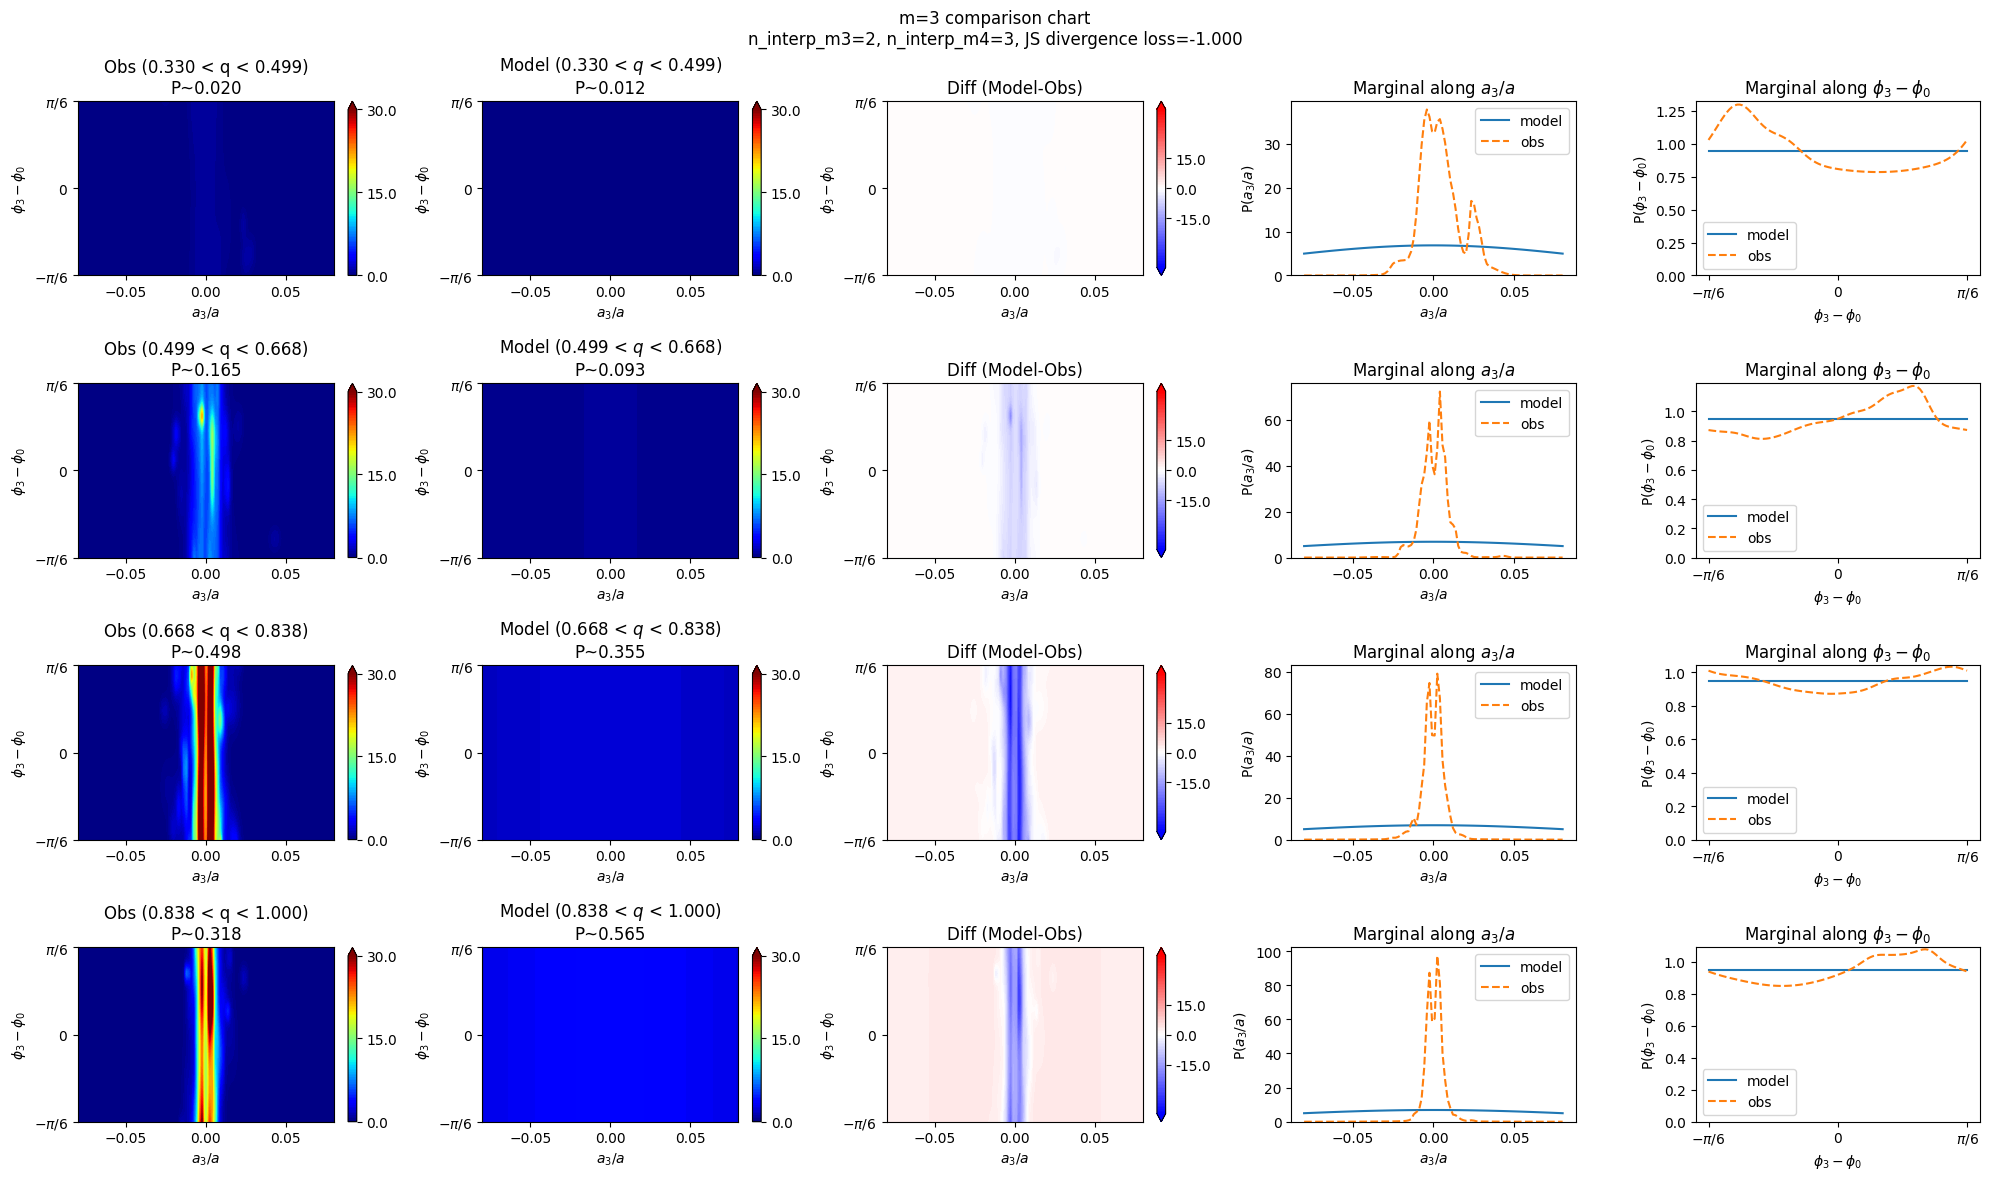

[m=4] Saved figure to init_params_fitting_result_m4_slices_test.pdf


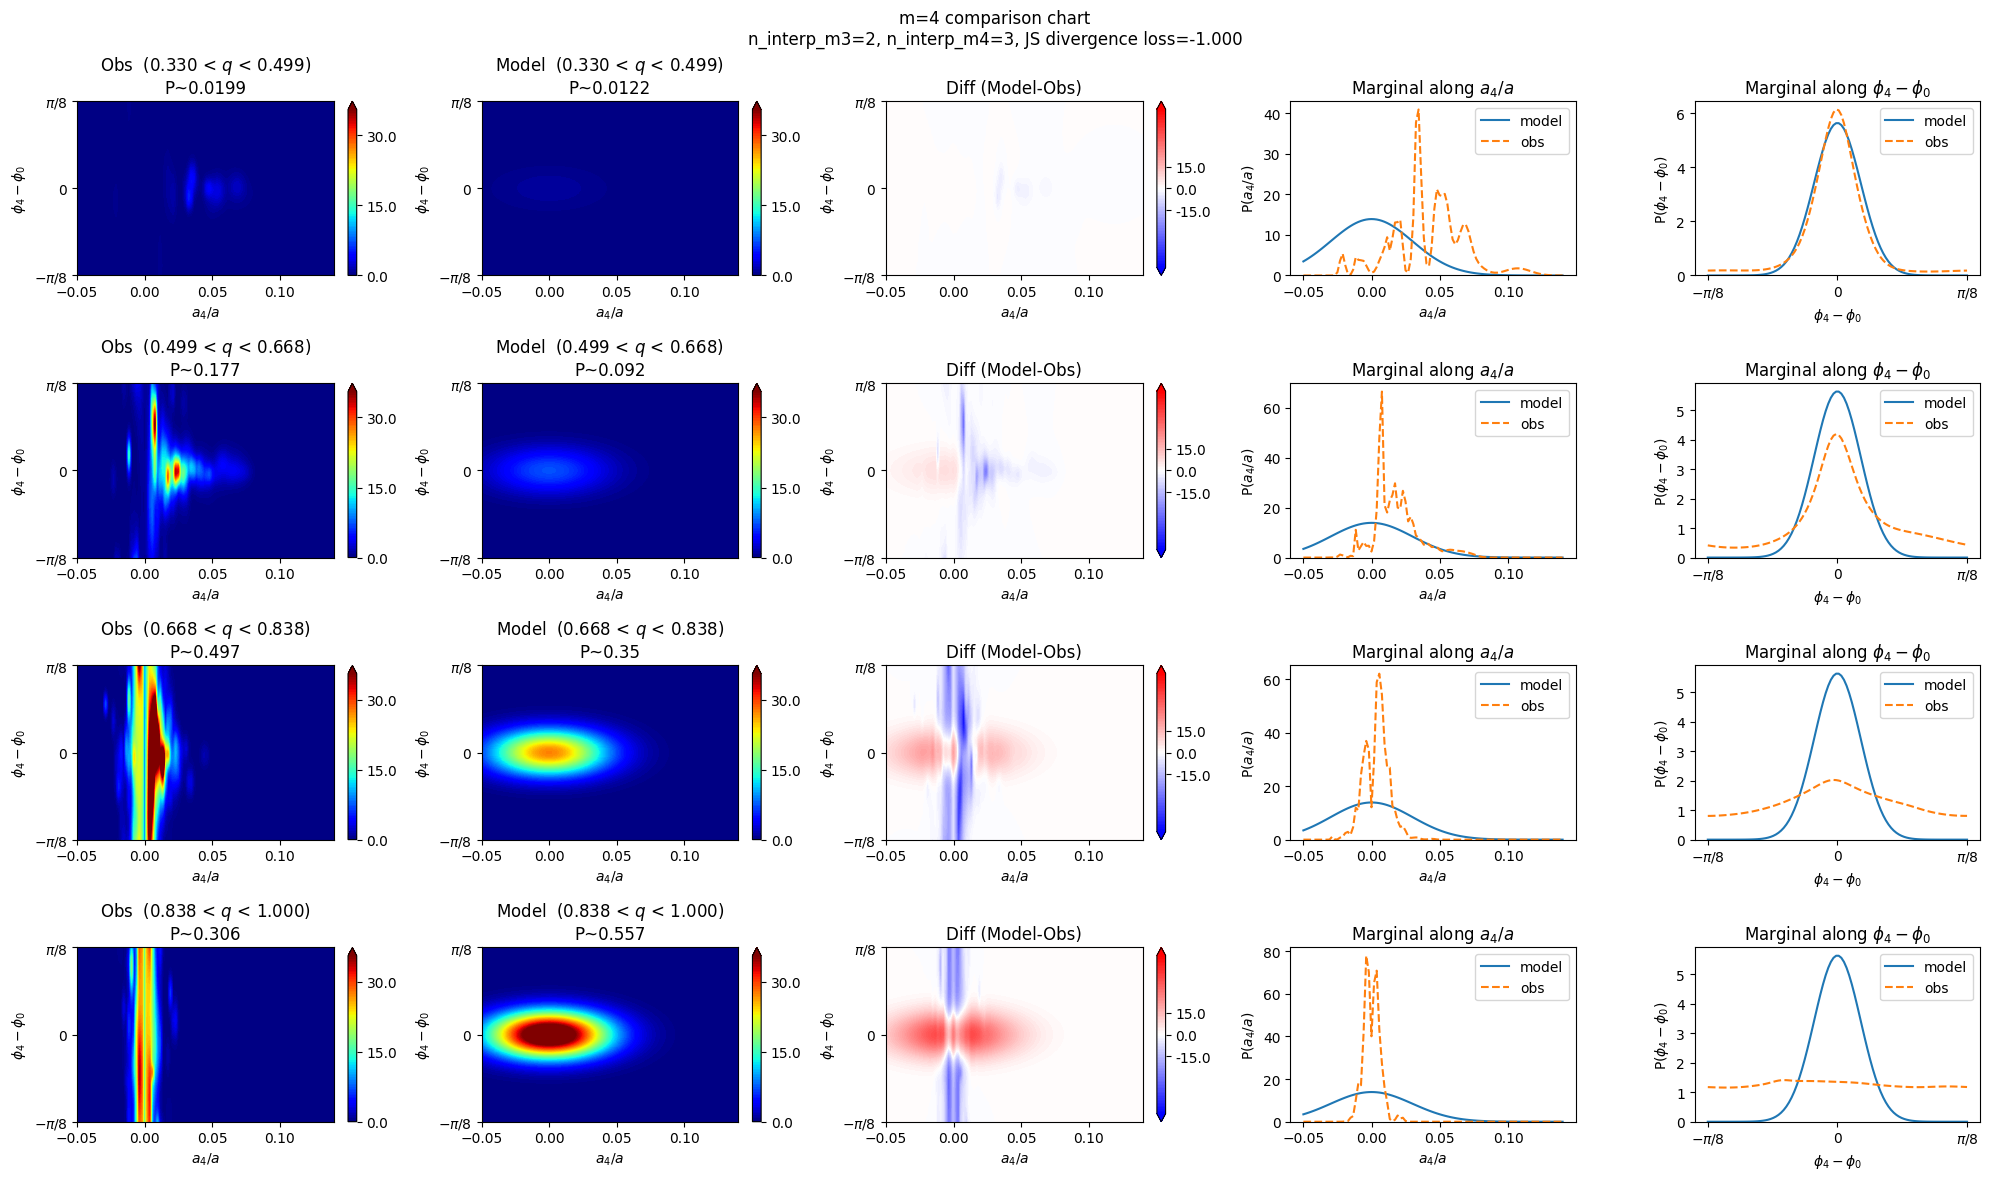

[m=3] Saved figure to init_params_fitting_result_P_Z_params_test.pdf


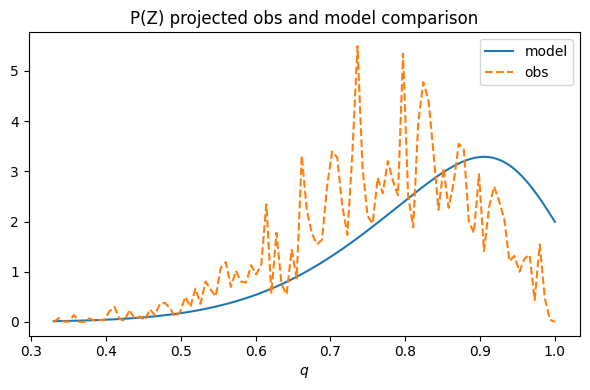

[m=3] Saved figure to init_params_fitting_result_m3_1_params_test.pdf


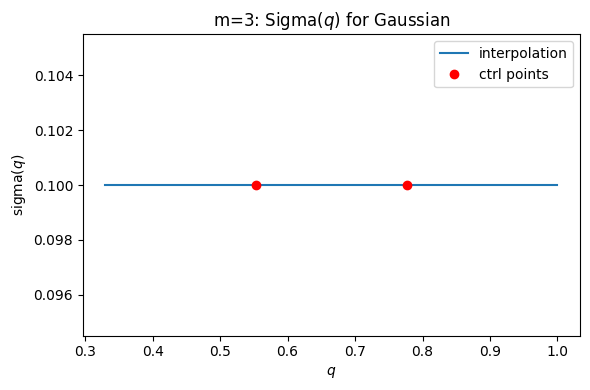

[m=4] Saved figure to init_params_fitting_result_m4_params_1_test.pdf


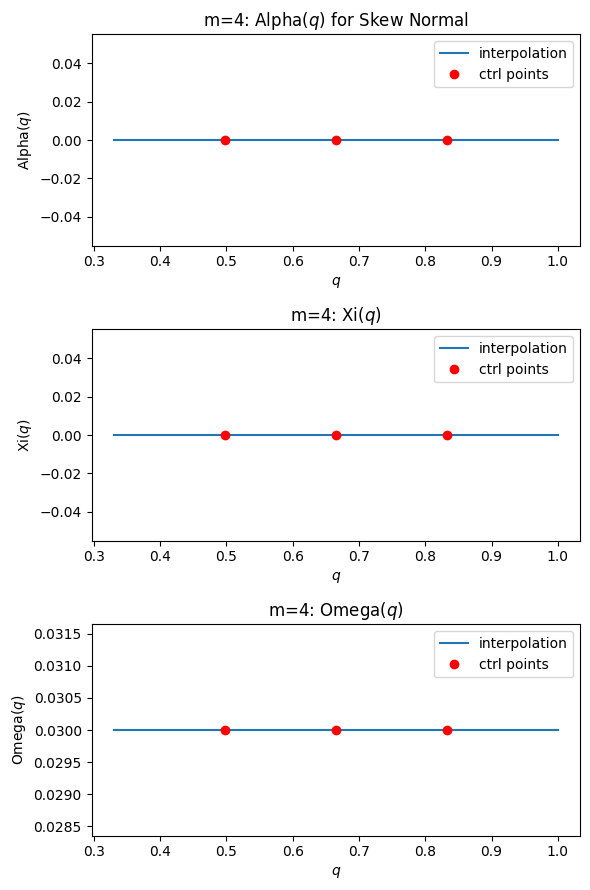

[m=4] Saved figure to init_params_fitting_result_m4_params_2_test.pdf


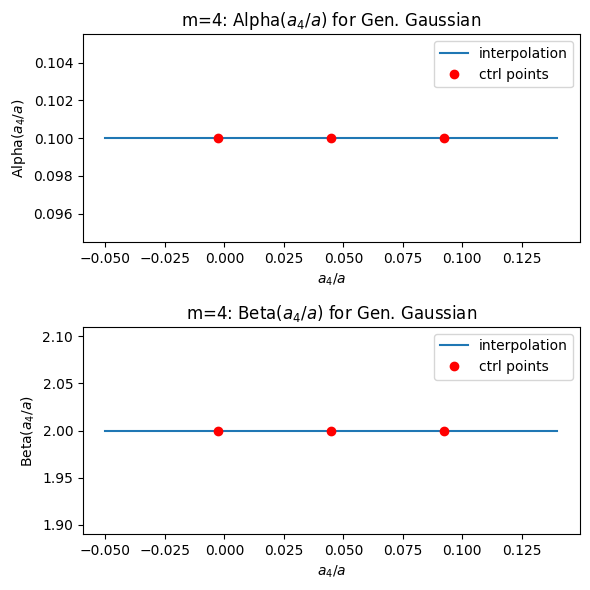

Using device: cpu
Epoch 10/5000, Loss=0.885825, JS3=0.475675 (normalized by ln2: 0.686254), JS4=0.410150 (normalized by ln2: 0.591721)
Epoch 20/5000, Loss=0.789243, JS3=0.467496 (normalized by ln2: 0.674454), JS4=0.321746 (normalized by ln2: 0.464182)
Epoch 30/5000, Loss=0.741987, JS3=0.457881 (normalized by ln2: 0.660582), JS4=0.284107 (normalized by ln2: 0.409879)
Epoch 40/5000, Loss=0.709713, JS3=0.443170 (normalized by ln2: 0.639358), JS4=0.266543 (normalized by ln2: 0.384541)
Epoch 50/5000, Loss=0.665006, JS3=0.413339 (normalized by ln2: 0.596322), JS4=0.251667 (normalized by ln2: 0.363079)
Epoch 60/5000, Loss=0.577857, JS3=0.337348 (normalized by ln2: 0.486691), JS4=0.240509 (normalized by ln2: 0.346981)
Epoch 70/5000, Loss=0.370388, JS3=0.139494 (normalized by ln2: 0.201247), JS4=0.230895 (normalized by ln2: 0.333111)
Epoch 80/5000, Loss=0.348831, JS3=0.126428 (normalized by ln2: 0.182397), JS4=0.222403 (normalized by ln2: 0.320860)
Epoch 90/5000, Loss=0.328999, JS3=0.114180 (no

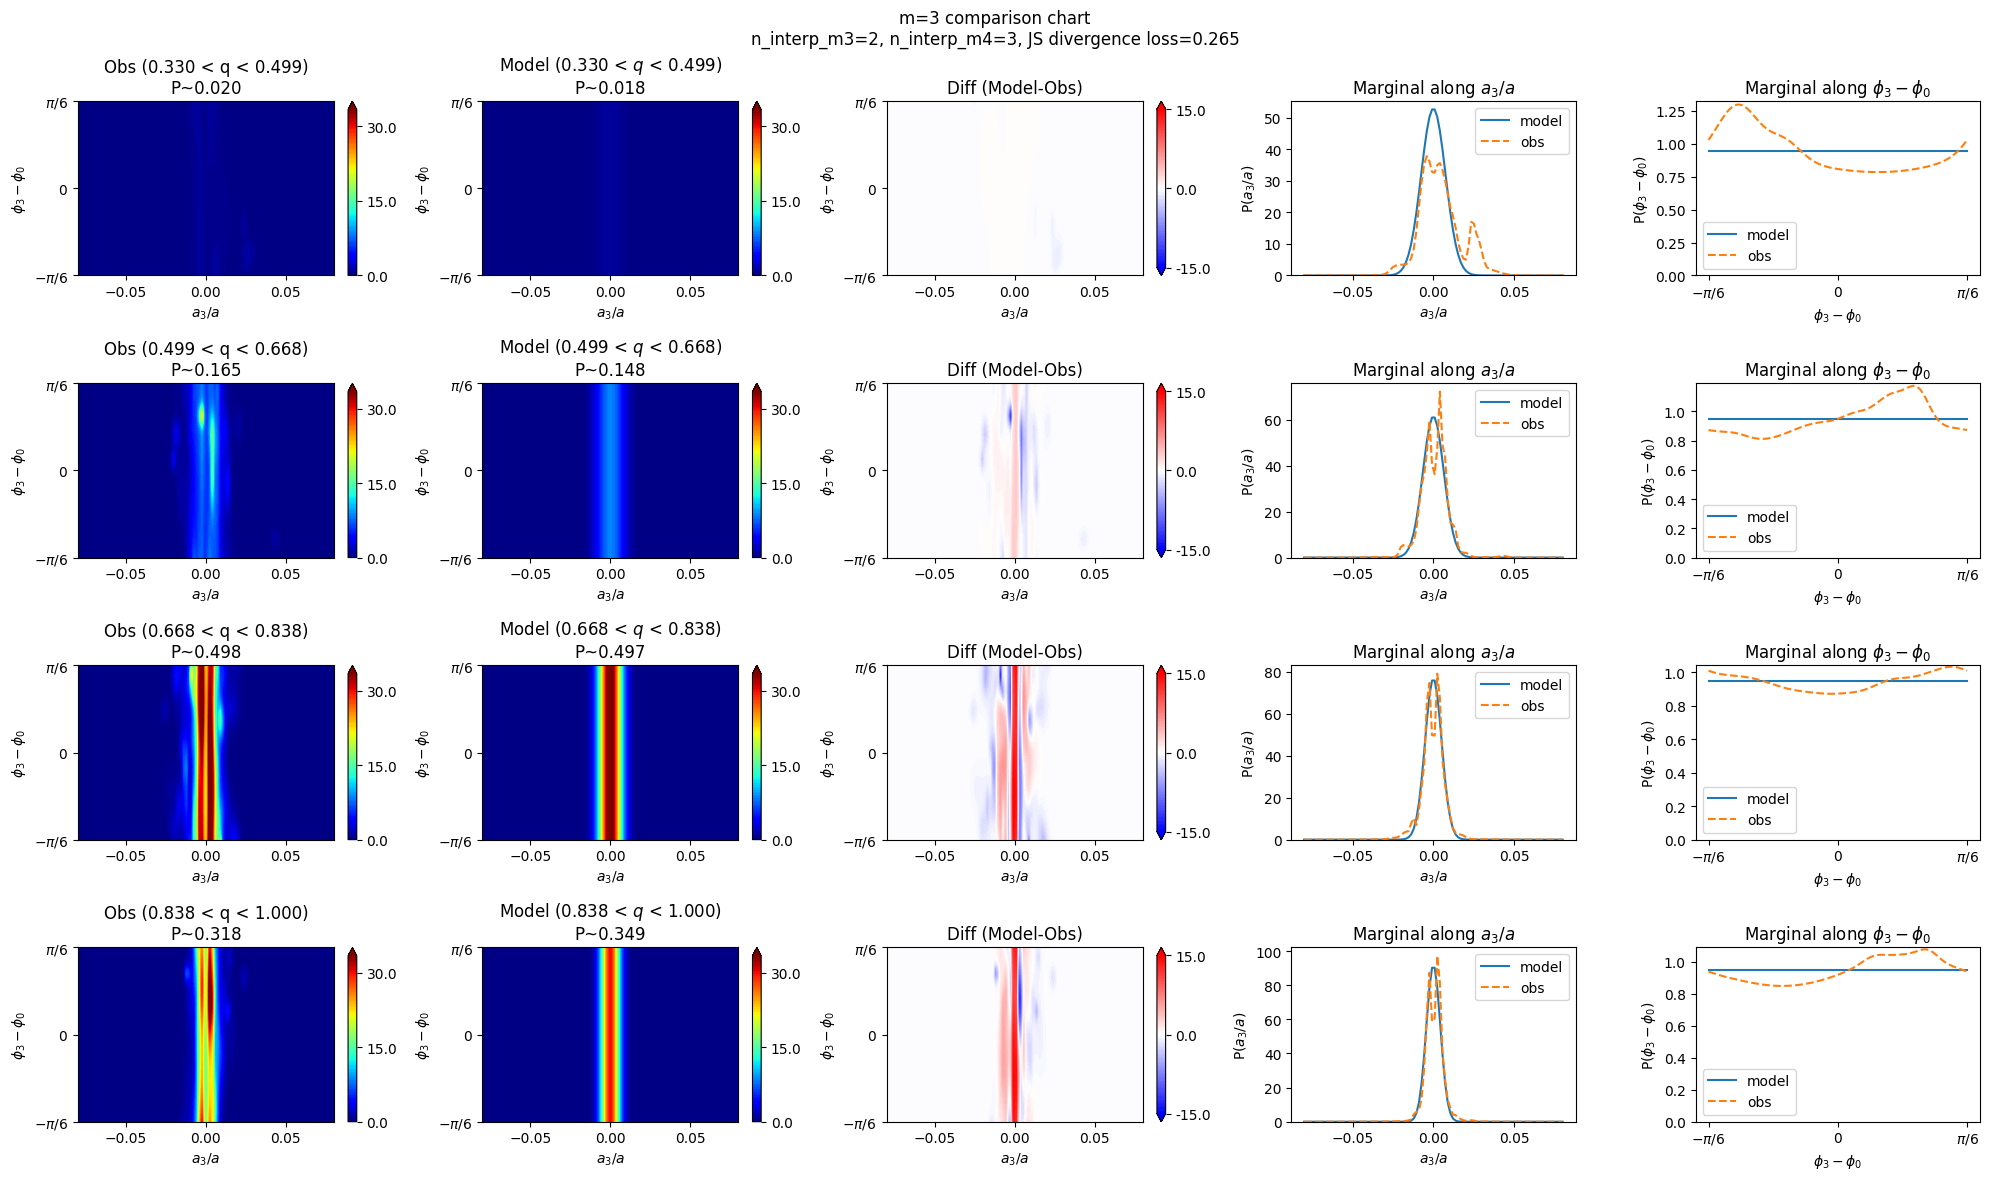

[m=4] Saved figure to n_interp_m3=2__n_interp_m4=3_fitting_result_m4_slices_test.pdf


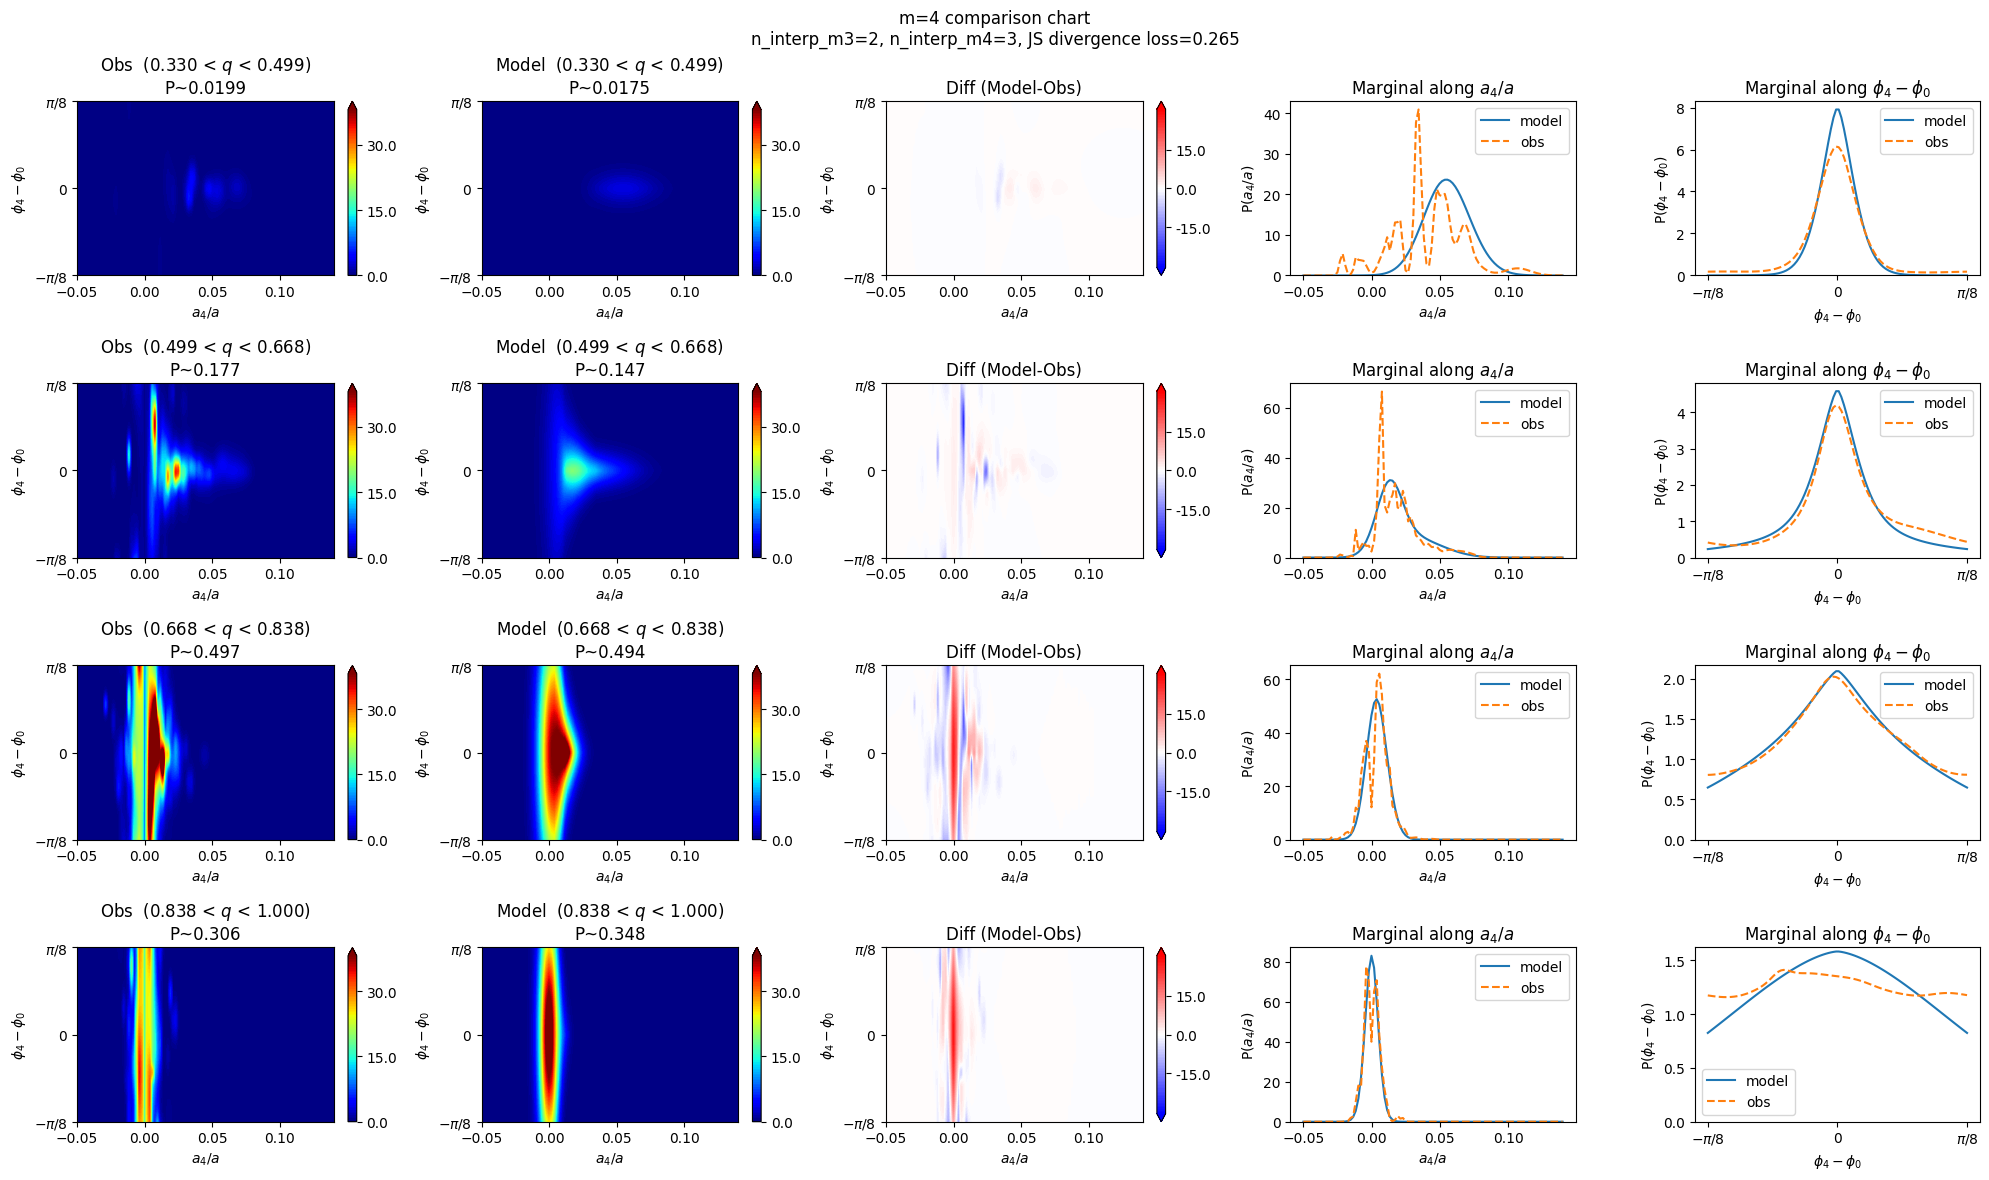

[m=3] Saved figure to n_interp_m3=2__n_interp_m4=3_fitting_result_P_Z_params_test.pdf


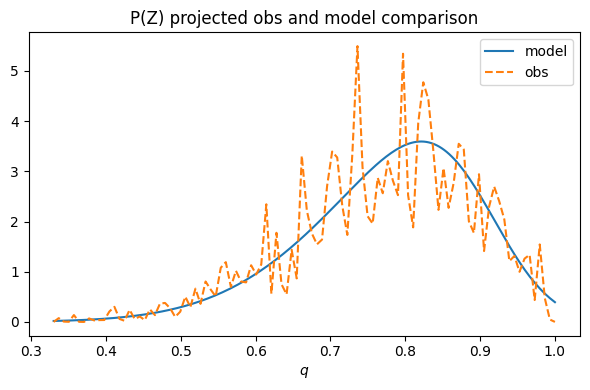

[m=3] Saved figure to n_interp_m3=2__n_interp_m4=3_fitting_result_m3_1_params_test.pdf


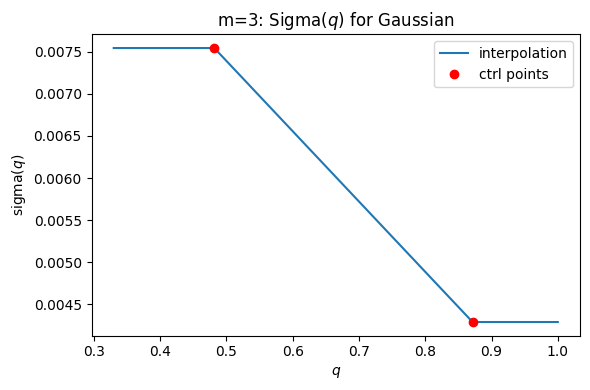

[m=4] Saved figure to n_interp_m3=2__n_interp_m4=3_fitting_result_m4_params_1_test.pdf


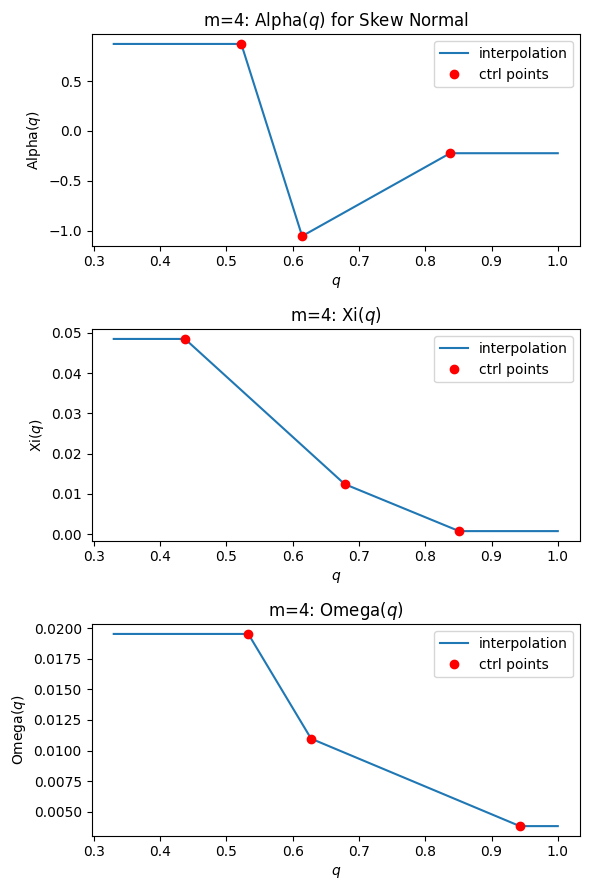

[m=4] Saved figure to n_interp_m3=2__n_interp_m4=3_fitting_result_m4_params_2_test.pdf


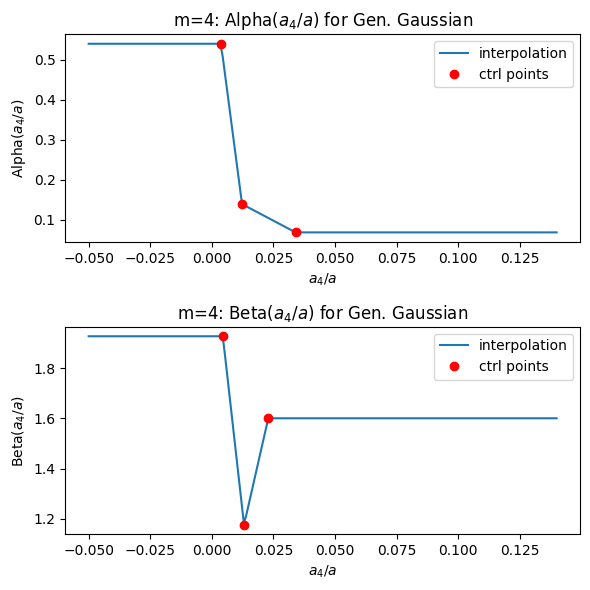

In [38]:
if __name__ == "__main__":
    z_parameters = {
        "alpha_Z": -3,
        "xi_Z": 1.0,
        "omega_Z": 0.2,
    }
    m3_parameters = {
        "sigma_z_x_ctrl_3": np.linspace(my_grid3.z_min, my_grid3.z_max, m3_rng_ini+2)[1:-1],
        "sigma_z_y_ctrl_3": 0.10 * np.ones(m3_rng_ini)
        # "alpha_x_ctrl_3":   [-0.04672103, -0.00894277, 0.00938972, 0.03047734, 0.0165878],
        # "beta_x_ctrl_3":    [-0.03801129, 0.00614626, -0.00732931, 0.00947411, 0.03892793],
        # "alpha_y_ctrl_3":   [2.5998, 2.8363, 0.7363, 0.3448, 1.3697],
        # "beta_y_ctrl_3":    [0.6019, 1.5902, 3.2148, 4.4088, 1.6012]
    }
    m4_parameters = {
        "alpha_z_x_ctrl_4": np.linspace(my_grid4.z_min, my_grid4.z_max, m4_rng_ini+2)[1:-1],
        "xi_z_x_ctrl_4": np.linspace(my_grid4.z_min, my_grid4.z_max, m4_rng_ini+2)[1:-1],
        "omega_z_x_ctrl_4": np.linspace(my_grid4.z_min, my_grid4.z_max, m4_rng_ini+2)[1:-1],
        "alpha_x_ctrl_4": np.linspace(my_grid4.x_min, my_grid4.x_max, m4_rng_ini+2)[1:-1],
        "beta_x_ctrl_4":  np.linspace(my_grid4.x_min, my_grid4.x_max, m4_rng_ini+2)[1:-1],
        #
        "alpha_z_y_ctrl_4": np.zeros(m4_rng_ini),
        "xi_z_y_ctrl_4": np.zeros(m4_rng_ini),
        "omega_z_y_ctrl_4": 0.03 * np.ones(m4_rng_ini),
        "alpha_y_ctrl_4": 0.1 * np.ones(m4_rng_ini),
        "beta_y_ctrl_4": 2 * np.ones(m4_rng_ini),
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = DistributionModel(
        z_parameters, m3_parameters, m4_parameters,
        my_grid3, my_grid4,
        n_interp_m3=len(m3_parameters["sigma_z_x_ctrl_3"]), n_interp_m4=len(m4_parameters["alpha_z_x_ctrl_4"]),
        use_identical_domain_m3=False,
        use_identical_domain_m4=False
    ).to(device)

    #%% Initial parameterization plot
    prefix="init_params"
    model.final_loss = -1 # placeholder
    print("===Plotting Before-Fitting Comparison===")
    plot_projections(model, P_X3Y3Z_Hao, P_X4Y4Z_Hao, my_grid3, my_grid4,
                             n_slices=n_slices_to_plot, save_path=result_path, prefix=prefix, suffix='test')
    plot_parameter_trends(model, my_grid3, my_grid4, save_path=result_path, prefix=prefix, suffix='test')

    #%%
    lr_base = 1e-3

    # Example: define optimizer and scheduler outside train_model
    optimizer = optim.Adam(model.parameters(), lr=lr_base)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

    # Train
    final_loss, optimizer, scheduler = train_model(
        model,
        P_X3Y3Z_Hao,  # loaded from data_for_torch_fitting_m=3.pkl
        P_X4Y4Z_Hao,  # loaded from data_for_torch_fitting_m=4.pkl
        n_epochs=n_epochs,
        device=device,
        optimizer=optimizer,
        scheduler=scheduler
    )
    model.final_loss = final_loss
    print("Final Loss:", final_loss)
    print("===After-Fitting Model Parameters===")
    print_all_model_params(model)
    print("===Plotting After-Fitting Comparison===")
    prefix = f"n_interp_m3={model.n_interp_m3}__n_interp_m4={model.n_interp_m4}"
    plot_projections(model, P_X3Y3Z_Hao, P_X4Y4Z_Hao, my_grid3, my_grid4,
                     n_slices=n_slices_to_plot, save_path=result_path, prefix=prefix, suffix='test')
    plot_parameter_trends(model, my_grid3, my_grid4, save_path=result_path, prefix=prefix, suffix='test')

    # Save final model parameters
    final_state = get_model_state(model)
    nkey = f"n_interp_m3={model.n_interp_m3}__n_interp_m4={model.n_interp_m4}"
    model.best_results[nkey] = {
        "params": final_state,
        "loss": final_loss
    }

    final_state = get_model_state(model)
    nkey = f"n_interp_m3={model.n_interp_m3}__n_interp_m4={model.n_interp_m4}"
    # nkey = f"n_interp_m3={model.n_interp_m3}__n_interp_m4={model.n_interp_m4}"
    model.best_results[nkey] = {
        "params": final_state,
        "loss": final_loss
    }
    model_savename_full = os.path.join(result_path, model_savename)
    torch.save(model.state_dict(), model_savename_full)
    with open(os.path.join(result_path, "best_results.json"), "w") as json_file:
                json.dump(model.best_results, json_file, indent=4)

In [39]:
print("===Done!===")

===Done!===


In [43]:
print("P(q) parameters:\n", "alpha: ", model.alpha_Z.detach().numpy(), "\n xi: ", model.xi_Z.detach().numpy(), "\n omega: ", model.omega_Z.detach().numpy())

P(q) parameters:
 alpha:  -2.490618 
 xi:  0.90942043 
 omega:  0.17501172


Calculating uncertainty of a4/a...
Calculating uncertainty of phi_4-phi_0...
Calculating uncertainty of a3/a...
i=41
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.00045476126671951294
i=438
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.0006427903509213329
i=512
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.0007157796956019898
i=572
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.000523775187609002
i=607
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.0005181074549802609
i=621
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.0005141397666939127
i=682
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.0004544373750073968
i=700
var_ri is negative, so trying the second order uncertainty
var_ri_2nd_order = 0.00044803259413639255
i=724
var_ri is negative, so trying the 

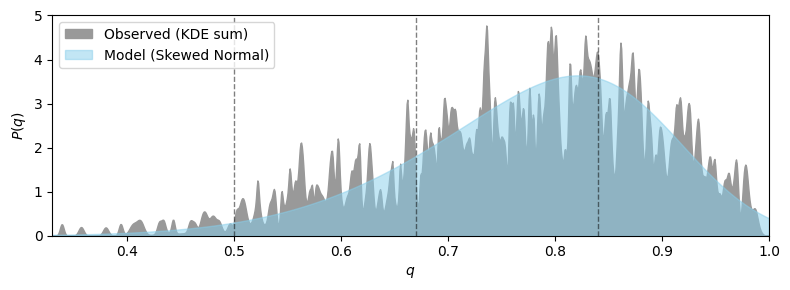

In [46]:
z_parameters = {'alpha_Z': model.alpha_Z.detach().numpy(), 'xi_Z': model.xi_Z.detach().numpy(), 'omega_Z': model.omega_Z.detach().numpy()}

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skewnorm

def generate_and_plot_distributions(q, dq, z_parameters, filename='P(q)_distribution_plot.pdf'):
    """
    Generates an observed distribution by convolving Gaussians defined by q and dq,
    and compares it to a skewed normal distribution defined by z_parameters.

    Parameters:
    - q: array-like, axis ratios
    - dq: array-like, uncertainties in axis ratios
    - z_parameters: dict with keys 'alpha_Z', 'xi_Z', 'omega_Z'
    - filename: name of the output file for the plot
    """

    # Create a common x-axis grid
    x = np.linspace(0.33, 1, 1000)

    # Observed distribution: sum of Gaussians
    observed_pdf = np.zeros_like(x)
    for qi, dqi in zip(q, dq):
        observed_pdf += norm.pdf(x, loc=qi, scale=dqi)

    observed_pdf /= np.trapz(observed_pdf, x)  # normalize

    # Model distribution: skewed normal
    alpha = z_parameters['alpha_Z']
    xi = z_parameters['xi_Z']
    omega = z_parameters['omega_Z']
    model_pdf = skewnorm.pdf(x, alpha, loc=xi, scale=omega)
    model_pdf /= np.trapz(model_pdf, x)  # normalize

    # Plot
    plt.figure(figsize=(8, 3))
    gray_scale=0.6
    plt.fill_between(x, observed_pdf, label='Observed (KDE sum)', color=(gray_scale, gray_scale, gray_scale) )
    plt.fill_between(x, model_pdf, label='Model (Skewed Normal)', alpha=0.5, color='skyblue')
    for x_i in [0.50, 0.67, 0.84]:
        plt.axvline(x=x_i, color='black', linestyle='--', linewidth=1.0, alpha=0.5)
    plt.xlabel(r'$q$')
    plt.ylabel(r'$P(q)$')
    plt.title(r'')
    plt.xlim(0.33, 1)
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Loading params again...
phot = np.loadtxt('./Data_Hao2006/photometry.dat')
vdis = np.loadtxt('./Data_Hao2006/veldis_corrected.dat')
# ellipticity = phot[:,5]
# q = 1-ellipticity
# inds_keep = np.where(vdis>vdis_minimum)
params = {}
param_names = ['Re', '_a3/a', '_delta_a3/a', '_a4/a', '_delta_a4/a', # 1-5
               'ellip', 'delta_ellip', '_b3/a', '_delta_b3/a', '_b4/a', # 6-10
               '_delta_b4/a',
              ]
# Full parameters
# Re	a3mean	a3mean_err	a4mean	a4mean_err	ellipmean	ellipmean_err	b3mean	b3mean_err	b4mean	b4mean_err	a3twist	a3twist_err	a3grad	a3grad_err	a4twist	a4twist_err	a4grad	a4grad_err	elliptwist	elliptwist_err	ellipgrad	ellipgrad_err	patwist	patwist_err	pagrad	pagrad_err	xtwist	xtwist_err	xgrad	xgrad_err	ytwist	ytwist_err	ygrad	ygrad_err	b3re	b3re_err	b4re	b4re_err	ellipre	ellipre_err	pare	pare_err	vdisp	vdisp_err	peR50	peR50_err	deVRad	deVRadErr	peMag_r	peMagErr_r	peMag_g	peMagErr_g	peMag_i	peMagErr_i	peR90	peR90_err	z	run	rerun	camcol	field	colci

params['vdis'] = vdis[:] #[inds_keep]

for i, param_name in enumerate(param_names):
    params[param_name]=phot[:,i]
params['pare'] = phot[:,41] # Position angle at PeR50 (Petrosian Half-light Radius)
params['q'] = 1 - params['ellip']
params['delta_q'] = params['delta_ellip']

#%%

from util import params_multipole_field_update, params_nan_clear
# phi3, phi4, a3/a, a4/a, delta_a3/a, delta_a4/a, delta_Dphi_3, delta_Dphi_4
params = params_multipole_field_update(params)
params = params_nan_clear(params)

# Loading params done

generate_and_plot_distributions(q=params['q'], dq=params['delta_q'], z_parameters=z_parameters)